In [1]:
# Standard library imports
import json
import os
import random
import sys
from pprint import pprint
from datetime import datetime
import xml.etree.ElementTree as ET

# Third party imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import Bbox, inset_axes

from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import random_split
from torch_geometric.data import Dataset, HeteroData
from torch_geometric.loader import DataLoader
from tqdm import tqdm

# Local application imports
sys.path.append("/pbs/home/e/erodrigu/TesisPhDEzequielRodriguez/Code")
from UHECRs_gnn import(SD433UMDatasetHomogeneous,
                       GNNWithAttentionDiscriminator3Heads,
                       GNNWithAttentionDiscriminator3HeadsDualInput,
                       MaskNodes,
                       MaskMdCounters,
                       SilentPrunner,
                       MaskRandomNodes,
)
from my_utils.my_basic_utils import (
    create_bins,
    filter_dataframe,
    print_banner_text,
)
from my_utils.my_style import MyStyle

# set PATHS
code_PATH = os.path.abspath(os.path.join(".."))
project_PATH = os.path.abspath(os.path.join(code_PATH, ".."))
data_PATH = os.path.join(project_PATH, "data")

os.environ['PATH'] = os.path.expanduser('~/.TinyTeX/bin/x86_64-linux') + ':' + os.environ['PATH']

### Version check

In [2]:
print(f"Torch version: {torch.__version__}")
print(f"Torch CUDA version: {torch.version.cuda}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}")

Torch version: 1.11.0
Torch CUDA version: 10.2
Cuda available: True
Torch geometric version: 2.4.0
Device is: cuda


In [3]:
!nvidia-smi

Tue Dec 31 20:14:30 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.256.02   Driver Version: 470.256.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:04:00.0 Off |                    0 |
| N/A   29C    P0    60W / 149W |    333MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Dataset Index Loading

In [4]:
folder_path = "/sps/pauger/users/erodriguez/PhotonDiscrimination/"
dir_path = "/sps/pauger/users/erodriguez/PhotonDiscrimination/JSONfiles/"
index = pd.DataFrame()

# indexes
primaries = ["Proton", "Photon"]
energy_bins = ["16.5_17.0", "17.0_17.5"]
atms = ["01", "03", "08", "09"]
indexes = [
    f"index_hadron_rec_{x}_{y}_{z}.csv"
    for x in primaries
    for y in energy_bins
    for z in atms
]

# create the index by appending
for index_name in indexes:
    proton_index = pd.read_csv(folder_path + index_name, on_bad_lines="skip")
    photon_rec_index = pd.read_csv(
        folder_path + index_name.replace("hadron", "photon"), on_bad_lines="skip"
    )
    index_ = pd.merge(
        proton_index,
        photon_rec_index,
        on=["filename", "atm_model", "shower_id", "use_id"],
        how="left",
    )
    index = pd.concat([index, index_], ignore_index=True)

index = index.drop_duplicates()
index = index.drop_duplicates(subset=["filename"])
# we won't train using iron
index["mass_group"] = index["filename"].str.split(pat="_", expand=True)[0]
index = index[index["mass_group"] != "Iron"]
print(f"Events before quality cuts: {len(index)}")

Events before quality cuts: 398227


In [5]:
index.describe()

/sps/pauger/users/erodriguez/envs/pyg/lib/python3.8/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,atm_model,shower_id,use_id,energyMC,zenithMC,showerSize,showerSizeError,isT5,is6T5,Xmax,...,nearestid,nCandidates,bLDF,isSaturated,muonNumber,electromagneticEnergy,photon_energy,s_250,equivalent_energy,M1
count,398227.000000,398227.000000,398227.000000,3.982270e+05,398227.000000,398227.000000,398227.000000,398227.000000,398227.000000,398227.000000,...,398227.0,398227.000000,398227.000000,398227.000000,3.982270e+05,3.982270e+05,3.981870e+05,398187.000000,3.979650e+05,3.979650e+05
mean,5.250465,624.671403,10.489314,1.238382e+17,0.677721,16.222010,1.188039,0.671835,0.671835,731.265860,...,0.0,7.788909,0.761453,0.116549,4.892502e+05,1.139049e+17,1.642059e+17,29.006530,1.202942e+17,-inf
std,3.345009,360.883823,5.766413,7.912391e+16,0.273104,17.278987,0.866914,0.469546,0.469546,97.612257,...,0.0,5.378215,0.426196,0.320883,5.960837e+05,7.390093e+16,8.526831e+18,32.499657,6.294315e+17,NaN
min,1.000000,0.000000,1.000000,3.162770e+16,0.005836,0.000000,0.000000,0.000000,0.000000,541.340000,...,0.0,0.000000,0.000000,0.000000,3.914030e+03,2.378890e+16,0.000000e+00,0.000000,0.000000e+00,-inf
25%,1.000000,312.000000,5.000000,5.628890e+16,0.470053,3.482985,0.674117,0.000000,0.000000,674.485000,...,0.0,4.000000,1.000000,0.000000,6.835660e+04,5.133390e+16,0.000000e+00,5.067435,3.012160e+16,NaN
50%,8.000000,625.000000,10.000000,9.965710e+16,0.698197,10.672800,1.193160,1.000000,1.000000,726.160000,...,0.0,8.000000,1.000000,0.000000,2.462760e+05,9.139500e+16,7.304100e+16,17.938700,8.349710e+16,9.208530e-02
75%,9.000000,937.000000,15.000000,1.788410e+17,0.903215,23.710200,1.749920,1.000000,1.000000,776.310000,...,0.0,12.000000,1.000000,0.000000,6.818540e+05,1.645770e+17,1.755365e+17,42.080150,1.730690e+17,9.090410e-01
max,9.000000,1249.000000,20.000000,3.161470e+17,1.134360,486.789000,25.041500,1.000000,1.000000,7344.800000,...,0.0,23.000000,1.000000,1.000000,3.569170e+06,3.127350e+17,5.210900e+21,245.140000,2.359760e+20,2.089770e+00


### Quality Cuts and Binning

In [6]:
index = index.sample(frac=1)
index.loc[index["filename"].str.contains("Photon"), "isPhoton"] = 1
index.loc[index["filename"].str.contains("Proton"), "isPhoton"] = 0

index["sin2zenith"] = np.sin(index["zenithMC"]) ** 2

# photon efficiency from fit from simulations
#index["est_efficiency"] = (
#    15.4074
#    + 17.4996 * (np.log10(index["energyMC"]) - 17)
#    - 12.7485 * index["sin2zenith"]
#    - 20.7650 * index["sin2zenith"] ** 2
#    - 13.1239 * (np.log10(index["energyMC"]) - 17) * index["sin2zenith"]
#)
#index["est_efficiency"] = expit(index["est_efficiency"])

feature_filters = {
    "zenithMC": {"filter_type": "range", "max_cut": np.deg2rad(45)},
    "photon_energy": {"filter_type": "range", "min_cut": 1},
    #"est_efficiency": {"filter_type": "range", "min_cut": 0.9},
    "isT5": {"filter_type": "value", "value_to_keep": 1}
}
index = filter_dataframe(index, feature_filters)

index, e_bin_centers, e_bin_edges, e_labels = create_bins(
    index,
    lower_val=10**16.5,
    upper_val=10**17.5,
    num=6,
    unbinned_col="energyMC",
    bin_column_name="e_bin",
    bin_width="equal_logarithmic",
)

index, z_bin_centers, z_bin_edges, z_labels = create_bins(
    index,
    lower_val=0,
    upper_val=np.sin(np.deg2rad(45)) ** 2,
    num=4,
    unbinned_col="sin2zenith",
    bin_column_name="z_bin",
    bin_width="equal",
)

index = index.loc[~index["e_bin"].isnull()]

# corrupted or problematic ADSTs
exclude_list = [
"Photon_17.0_17.5_011102_11",
"Photon_17.0_17.5_080595_20"
]
index = index[~index['filename'].isin(exclude_list)]

print(f"Events after quality cuts: {len(index)}")

Events after quality cuts: 209158


### Balanced Dataset Division

In [7]:
# def get_fatt_ph(sec, dsec):
#     def func(x, p0, p1, p2, p3):
#         return p0 * (1 + (x - p2) / p1)**(p1 / p3) * np.exp(-(x - p2) / p3)

#     # Parameters and their errors
#     popt = [3.88940e+01, 6.23117e-01, 1.00999e+00, 9.04938e-02]
#     perr = [5.62431e-02, 5.26757e-02, 2.32738e-03, 4.79750e-03]

#     # Evaluate the function
#     f = func(sec, *popt)

#     # Unpack parameters and their errors
#     f0, f1, f2, f3 = popt
#     df0, df1, df2, df3 = perr

#     # Calculate the error
#     factor = 1 + (sec - f2) / f1
#     var0 = (f * df0 / f0)**2
#     var1 = (f * (np.log(factor) / f3 - (sec - f2) / (f1 * f3 * factor)) * df1)**2
#     var2 = (f * (f2 - sec) * df2 / (f3 * (f2 - sec - f1)))**2
#     var3 = (f * (f1 * np.log(factor) - sec + f2) * df3 / f3**2)**2
#     var4 = (-f * (sec - f2) * dsec / (f3 * (sec - f2 + f1)))**2
#     df = np.sqrt(var0 + var1 + var2 + var3 + var4)

#     return [f, df]

# def get_norm_fatt_ph(sec, dsec):
#     v_fatt_ph = get_fatt_ph(sec, dsec)
#     secref = np.cos(30 * np.pi / 180)**-1
#     norm = get_fatt_ph(secref, 0)[0]
#     v = [v_fatt_ph[0] / norm, v_fatt_ph[1] / norm]
#     return v

# def get_fatt_pr(x, dx):
#     def func(x, a, b, c):
#         return 1 + a * x + b * x**2 + c * x**3

#     # Parameters and their errors
#     popt = [1.88357, -1.74331, -3.45984]
#     perr = [2.81332e-03, 1.45271e-02, 5.38753e-02]

#     # Evaluate the function
#     f = func(x, *popt)

#     # Unpack parameters and their errors
#     f1, f2, f3 = popt
#     df1, df2, df3 = perr

#     # Calculate the error
#     var1 = (x * df1)**2
#     var2 = (x**2 * df2)**2
#     var3 = (x**3 * df3)**2
#     varx = ((f1 + 2 * f2 * x + 3 * f3 * x**2) * dx)**2
#     df = np.sqrt(var1 + var2 + var3 + varx)

#     return [f, df]

# def get_photon_norm():
#     secref = np.cos(30 * np.pi / 180)**-1
#     photon_norm = get_fatt_ph(secref, 0)[0]
#     return photon_norm

# photon_norm = get_photon_norm()

# x = np.cos(np.deg2rad(30))**2 - np.cos(np.deg2rad(30))**2
# dx = 1
# alpha = 1.15 * (1 - 0.192 * pow(pow(np.cos(np.deg2rad(30)), 2), 2.96))
# eq_energy = pow(10,16) * pow((38.9545 / (get_fatt_pr(x, dx)[0]*photon_norm)), (1/alpha))

In [8]:
# Combine label and the two categorical variables for stratified sampling
index["categorical_balance"] = (
    index["isPhoton"].astype(str)
    + "_"
    + index["e_bin"].astype(str)
    + "_"
    + index["z_bin"].astype(str)
)

random_seed = 42
stratified_split = StratifiedShuffleSplit(
    n_splits=1, test_size=0.25, random_state=random_seed
)

for dev_index_, test_index_ in stratified_split.split(
    index, index["categorical_balance"]
):
    # Original Training set
    dev_index = index.iloc[dev_index_]

    # Testing set
    test_index = index.iloc[test_index_]

# Further split the original training set into train and validation sets
validation_size = 0.25  # Adjust as needed
split = StratifiedShuffleSplit(
    n_splits=1, test_size=validation_size, random_state=random_seed
)

for train_index_, validation_index_ in split.split(
    dev_index, dev_index["categorical_balance"]
):
    train_index = dev_index.iloc[train_index_]
    validation_index = dev_index.iloc[validation_index_]

# Print the size of each dataset
print("Train dataset size:", train_index.shape[0])
print("Validation dataset size:", validation_index.shape[0])
print("Test dataset size:", test_index.shape[0])

Train dataset size: 117651
Validation dataset size: 39217
Test dataset size: 52290


### Datasets and Loaders

In [9]:
dir_path = "/sps/pauger/users/erodriguez/PhotonDiscrimination/JSONfiles/"
root_path = "/sps/pauger/users/erodriguez/PhotonDiscrimination/root/"

# Function to construct paths based on DataFrame columns
def construct_path(row, base_path):
    return f"{base_path}{row['mass_group']}/{row['filename']}.json"

# Set paths according to index
train_paths = train_index.apply(lambda row: construct_path(row, dir_path), axis=1).tolist()
val_paths = validation_index.apply(lambda row: construct_path(row, dir_path), axis=1).tolist()

test_run = True

if test_run:
    # subset for code testing
    train_paths = train_paths[:100]
    val_paths = val_paths[:1000]

In [14]:
norm_dict_computed = True
augmentation_and_normalization_options={"mask_PMTs":True,
                                        "AoP_and_saturation":True,
                                        "log_normalize_traces":True,
                                        "log_normalize_signals":True,
                                        "mask_MD_mods":True}

if not norm_dict_computed:
    # process the dataset
    train_PyG_ds = SD433UMDatasetHomogeneous(
        file_paths=train_paths,
        root=root_path,
        augmentation_options=augmentation_and_normalization_options)
    # compute statistics required for standardization
    normalization_dict = train_PyG_ds.compute_normalization_params(features=["x",
                                                                             "y",
                                                                             "z",
                                                                             "deltaTimeHottest",
                                                                             "WCD_signal"])
    # set values for min-max normalization
    normalization_dict["pmt_number"] = {"min": 1,
                                        "max": 3,
                                        "method": "min_max_scaling"}
    normalization_dict["effective_area"] = {"min": 0,
                                            "max": 3 * 10.46,
                                            "method": "min_max_scaling"}
    normalization_dict["rho_mu"] = {'min': -2.0,
                                    'method': 'min_max_scaling',
                                    'max': (64*3)/(3*10*np.cos(np.deg2rad(45)))}
    # print the dict to overwrite the code below
    pprint(normalization_dict)
else:
    normalization_dict = {
                         #'WCD_signal': {'mean': 0.15697795152664185,
                         #                'method': 'standardization',
                         #                'std': 0.28036314249038696},
                         'deltaTimeHottest': {'mean': -13.743452072143555,
                                              'method': 'standardization',
                                              'std': 446.0340270996094},
                         'effective_area': {'max': 31.380000000000003,
                                            'method': 'min_max_scaling',
                                            'min': 0},
                         'pmt_number': {'max': 3, 'method': 'min_max_scaling', 'min': 1},
                         #'rho_mu': {'min': -2.0,
                         #           'method': 'min_max_scaling',
                         #           'max': (64*3)/(3*10*np.cos(np.deg2rad(45)))},
                         #'rho_mu':{'mean': 0.21510971141596952,
                         #          'method': 'standardization',
                         #          'std': 0.9057438827119321},
                         'x': {'mean': -2.081512212753296,
                               'method': 'standardization',
                               'std': 779.2147827148438},
                         'y': {'mean': 0.3692401945590973,
                               'method': 'standardization',
                               'std': 779.95458984375},
                         'z': {'mean': -0.17404018342494965,
                               'method': 'standardization',
                               'std': 9.372444152832031}}

In [ ]:
from torch_geometric.data import Dataset, Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import subgraph, dropout_node

class MaskMdCounters(BaseTransform):
    def __init__(self, rho_mu_column_idx, effective_area_column_idx, silent_value: float = 1.0):
        """
        Args:
            rho_mu_column_idx (int): The index of the rho_mu column in data.x.
            effective_area_column_idx (int): The index of the effective_area column in data.x.
        """
        super(MaskMdCounters, self).__init__()
        self.rho_mu_column_idx = rho_mu_column_idx
        self.effective_area_column_idx = effective_area_column_idx
        self.silent_value = silent_value

    def __call__(self, input_data):
        """
        Modify the specified rho_mu and effective_area columns in data.x by randomly setting values to -2 
        in the rho_mu column, and setting values to 0 in the effective_area column for the same rows.

        Args:
            input_data (torch_geometric.data.Data): The data object containing graph information.

        Returns:
            torch_geometric.data.Data: The modified data object.
        """
        data = input_data.clone()  # Clone the input data to avoid modifying the original
        
        # Get the values from the rho_mu column
        rho_mu_values = data.x[:, self.rho_mu_column_idx]

        # Find the indices of rows where the rho_mu value is not equal to the value set to silent stations (-1 if not normalized)
        valid_rows = torch.where(rho_mu_values != self.silent_value)[0]

        # Calculate the number of valid rows
        num_valid_rows = valid_rows.size(0)

        # Randomly determine how many rows to modify, a number between 0 and max(0, num_valid_rows - 3)
        max_rows_to_modify = max(0, num_valid_rows - 3)
        num2modify = torch.randint(0, max_rows_to_modify + 1, (1,)).item()  # Random number between 0 and max_rows_to_modify

        # Randomly choose rows to modify
        if num2modify > 0:
            rows2modify = valid_rows[torch.randperm(num_valid_rows)[:num2modify]]

            # Set the selected rows' rho_mu column values to -2 if not normalized
            data.x[rows2modify, self.rho_mu_column_idx] = -1.0

            # Set the selected rows' effective_area column values to 0
            data.x[rows2modify, self.effective_area_column_idx] = 0

        return data

    def collate(self, batch):
        """
        Collate function to apply the transformation to a batch of graphs.
        """
        new_graphs = []
        for graph_batch_id in torch.unique(batch.batch):
            # Get features for this specific graph in the batch
            graph_mask = graph_batch_id == batch.batch
            _graph_x = batch.x[graph_mask]
            _graph_y = batch.y[graph_batch_id]
            _graph_x_traces = batch.x_traces[graph_mask]
            _station_list = batch.station_list[graph_batch_id]
            _seed = batch.seed[graph_batch_id]
            _pos = batch.pos[graph_mask]
            _energy_MC = batch.energy_MC[graph_batch_id]
            _id = batch.id[graph_batch_id] 

            # Get graph edges
            nodes2keep = torch.arange(batch.ptr[graph_batch_id], batch.ptr[graph_batch_id+1])
            _graph_x_edge_index, _ = subgraph(nodes2keep, edge_index=batch.edge_index.long(), relabel_nodes=True, num_nodes=len(batch.batch))

            # Create a new subgraph with the pruned nodes
            new_graph = Data(x=_graph_x, edge_index=_graph_x_edge_index, pos=_pos)
            new_graph.x_traces = _graph_x_traces
            new_graph.station_list = _station_list
            new_graph.y = _graph_y
            new_graph.energy_MC = _energy_MC
            new_graph.seed = _seed
            new_graph.id = _id
            new_graphs.append(new_graph)            

        # Use the Batch class to collate the transformed graphs
        return Batch.from_data_list([self(graph) for graph in new_graphs])

In [88]:
include_silent = False
dual_input = True

# transformations for individual input
masking_transformation_sd =  MaskNodes(max_nodes2prune=15)
masking_transformation_md =  MaskMdCounters(rho_mu_column_idx=7, effective_area_column_idx=6, silent_value=-1.0)

# transformations for dual input
silent_prunner = SilentPrunner(silent_col_index = 4, silent_value=-0.5)
random_masking = MaskRandomNodes(max_nodes2prune=2)

val_PyG_ds = DataLoader(SD433UMDatasetHomogeneous(file_paths=val_paths,
                              root=root_path,
                              augmentation_options=augmentation_and_normalization_options,
                              normalization_dict=normalization_dict,
                              include_silent=include_silent),
                              batch_size=100, num_workers=8)

In [89]:
for batch_idx, data in enumerate(tqdm(val_PyG_ds, desc=f"Subset Training", position=0, leave=True)):
    # Apply transformations
    data_sd = masking_transformation_sd.collate(data)
    if dual_input:
        # dual input
        data_sd_no_silent = silent_prunner.collate(data_sd)
        data_sdmd = random_masking.collate(data_sd_no_silent)
    else:
        # single input
        data_sdmd = masking_transformation_md.collate(data_sd)
    break

Subset Training:   0%|          | 0/10 [00:05<?, ?it/s]


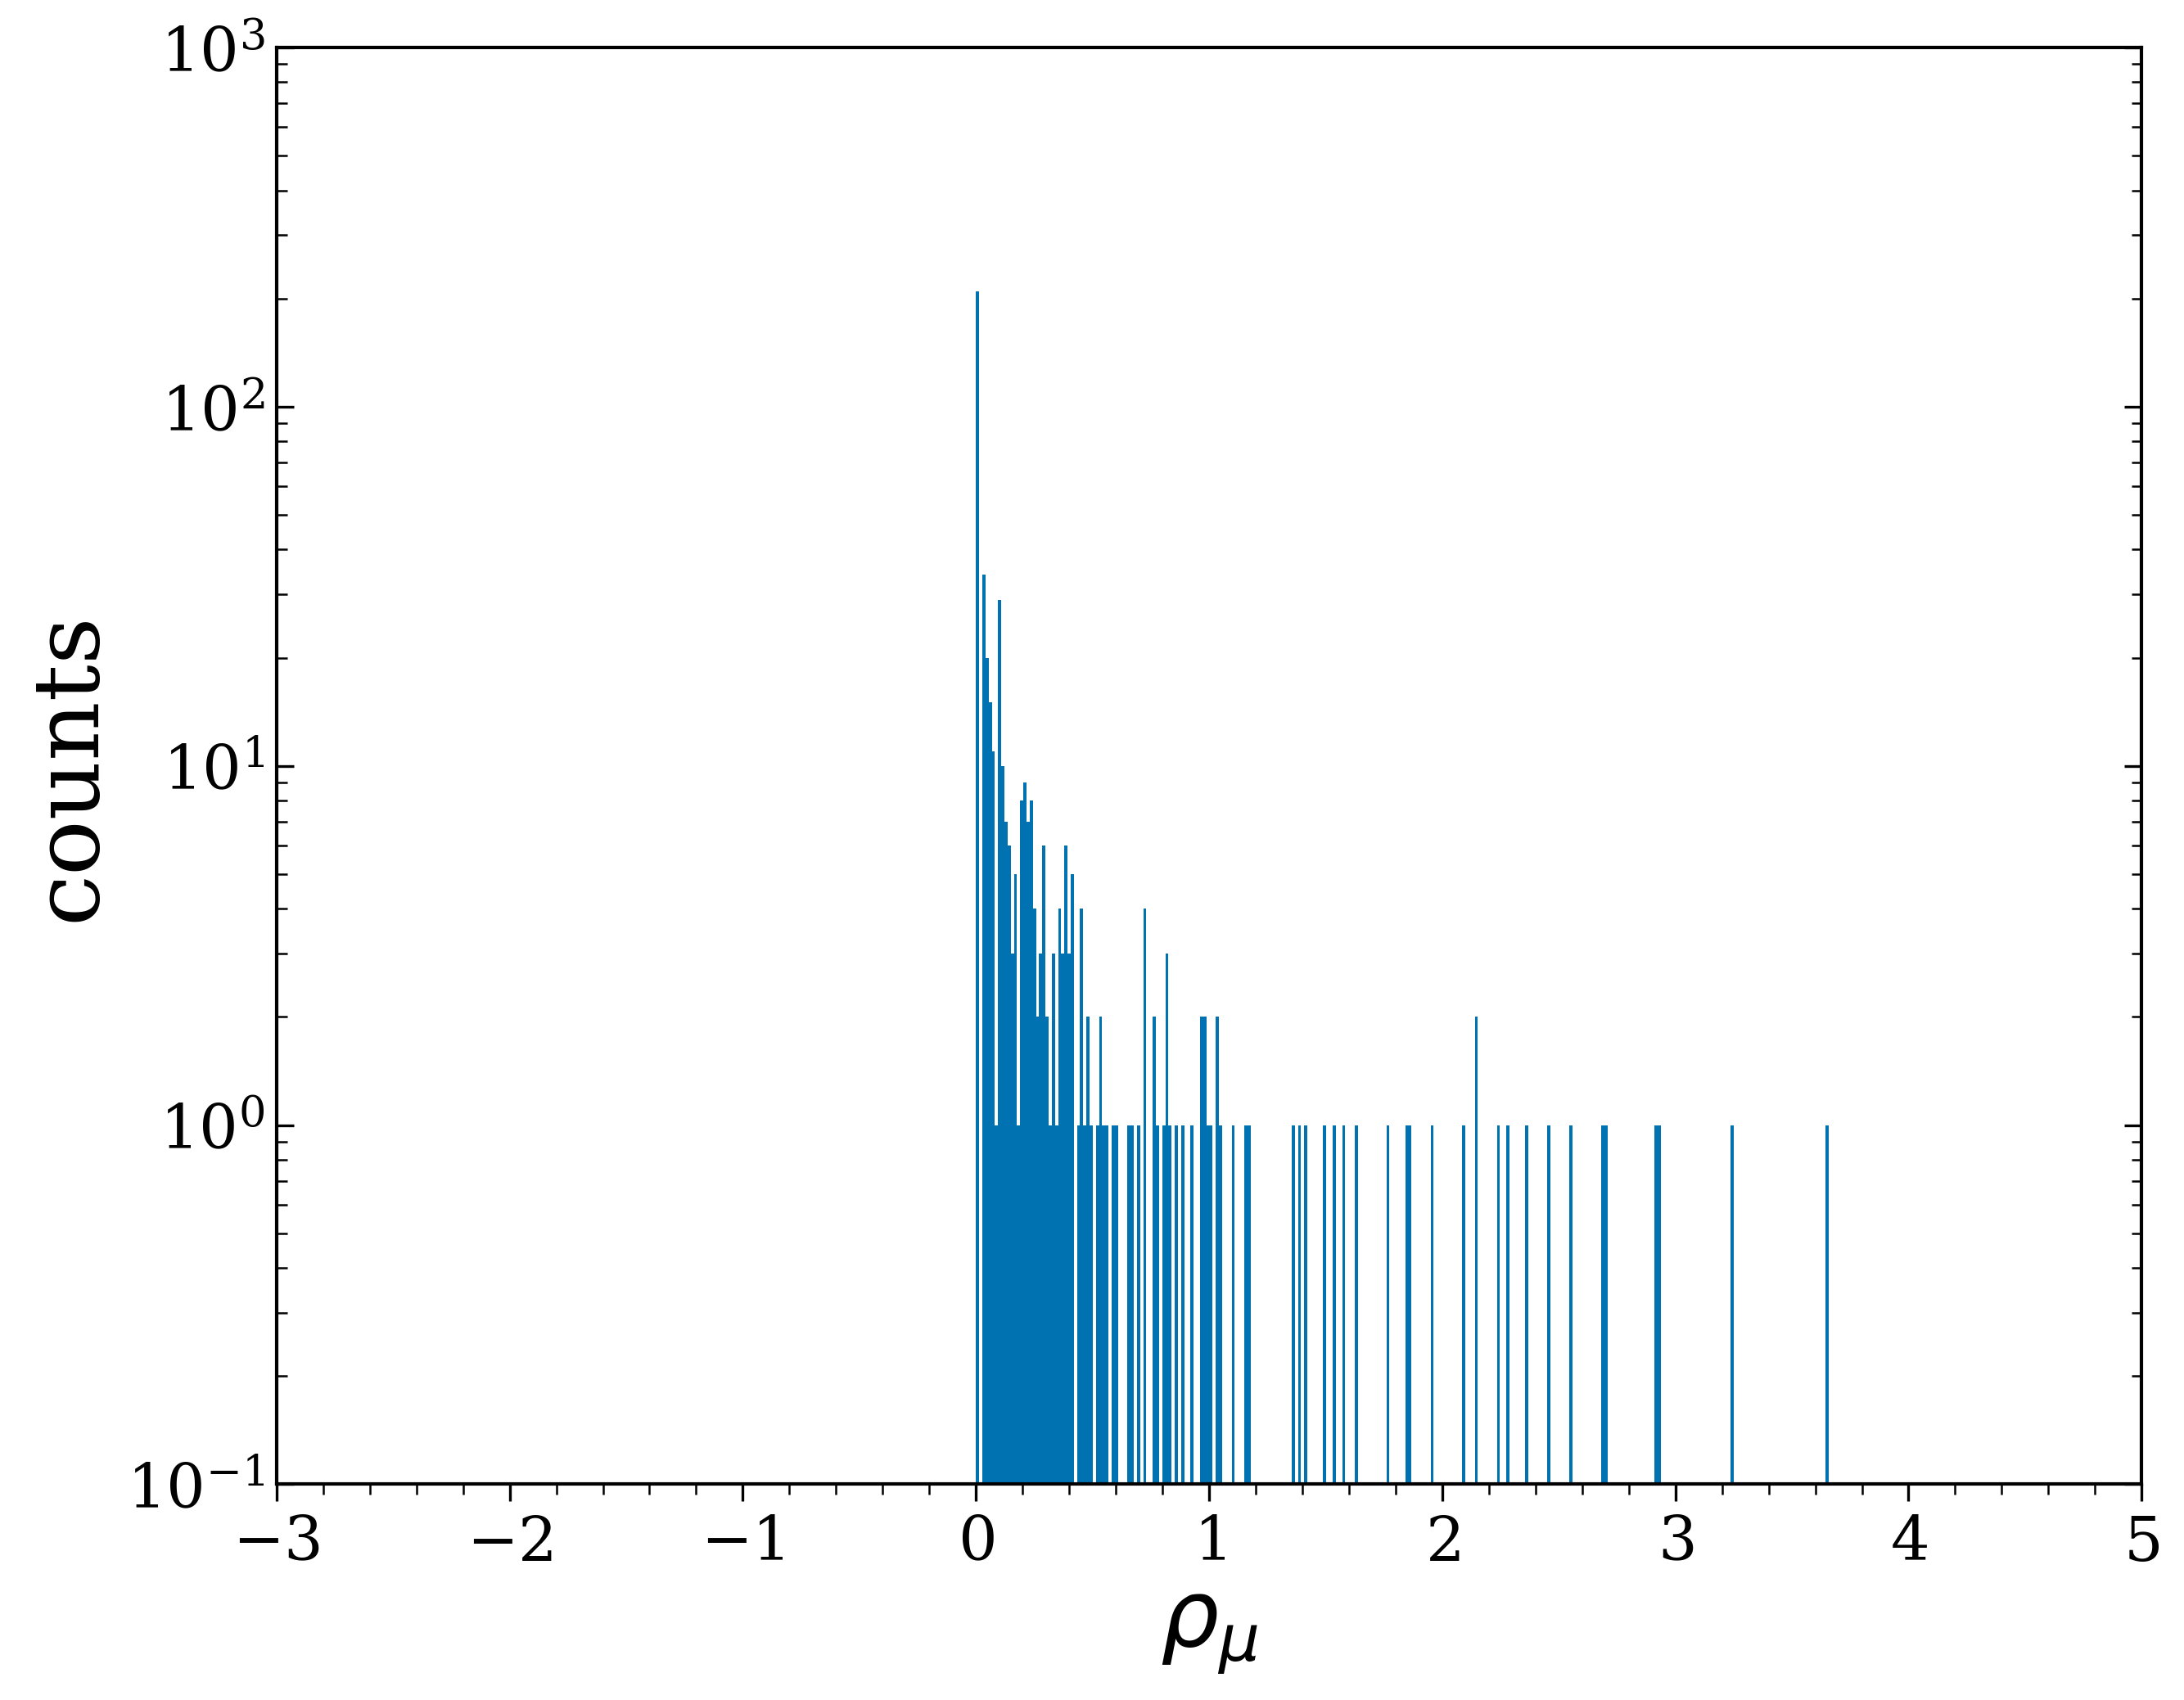

In [91]:
myStyle = MyStyle('1fig', markers=None) 
myStyle.reset_markers()

from matplotlib import rc
rc('text', usetex=False)

fig, ax = plt.subplots()

ax.hist(data_sdmd.x[:,7], bins=1000)
ax.set_ylabel("counts")
ax.set_xlabel(r"$\rho_{\mu}$")
ax.set_xlim(-3, 5)
ax.set_yscale("log")
plt.show()

In [21]:
graph = data[0]

In [22]:
def plot_simple_graph(graph, ax, kw_args_nodes, kw_args_edges, kw_args_traces, plot_edges=True, plot_traces=True, ):
    
    # plotting edges
    if plot_edges:
        
        for src, dst in graph["edge_index"].t().tolist():
            ax.plot(
                [
                    graph["pos"][src, 0],
                    graph["pos"][dst, 0],
                ],
                [graph["pos"][src, 1], graph["pos"][dst, 1]],
                **kw_args_edges, linewidth=1
            )
            
    # plotting nodes
    for i, (x, y) in enumerate(graph["pos"]):
        
        plt.scatter(x, y, **kw_args_nodes, )
        
        if plot_traces:
            inset_ax = ax.inset_axes(
            [x.item() - 100, y.item() + 25, 200, 100], transform=ax.transData
            )
            inset_ax.plot(graph.x_traces[i, :], color="blue", **kw_args_traces, linewidth=2)
            inset_ax.axis("off")

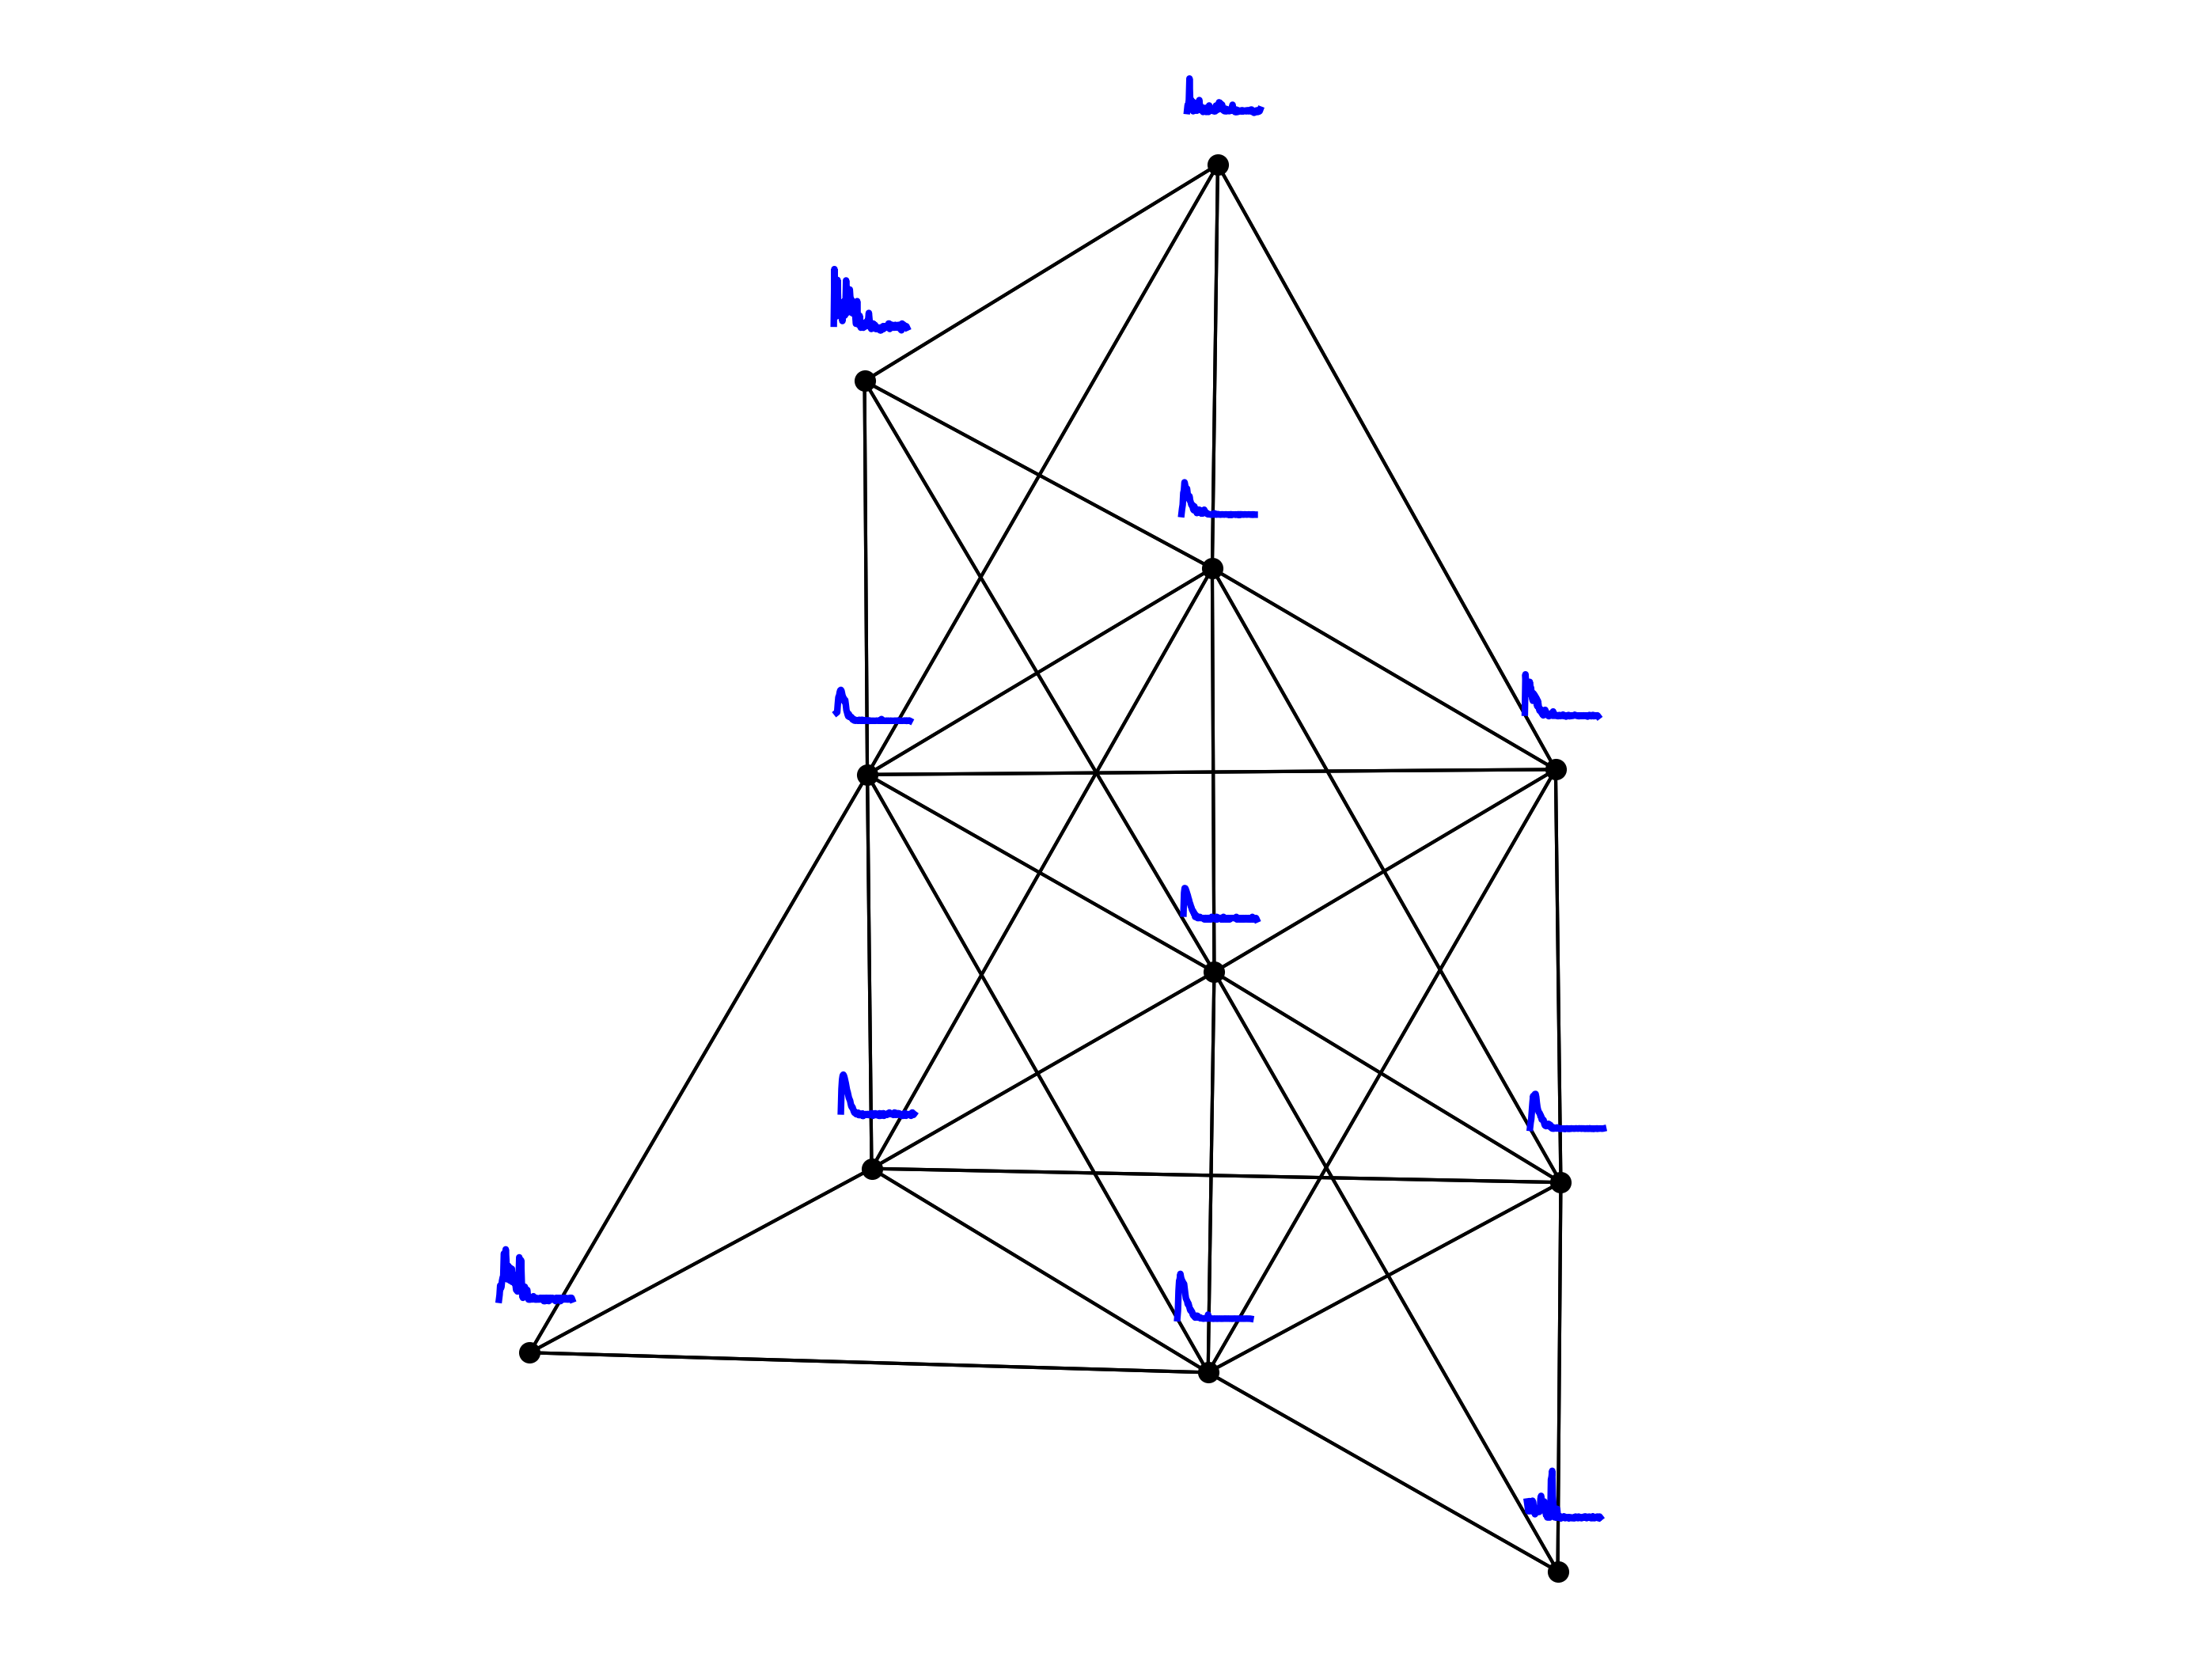

In [23]:
myStyle = MyStyle("1fig", markers=None)
fig, ax = plt.subplots()

color="black"
kw_args_nodes = {"color":color}
kw_args_edges = {"color":color}
kw_args_traces = {}

plot_simple_graph(graph, ax=ax, plot_traces=True, kw_args_nodes=kw_args_nodes, kw_args_edges=kw_args_edges, kw_args_traces=kw_args_traces)
ax.axis("off")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [67]:
from torch_geometric.data import Dataset, Data, Batch
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import subgraph, dropout_node

class MaskNodes(BaseTransform):
    def __init__(self, max_nodes2prune=20):
        super(MaskNodes, self).__init__()
        self.max_nodes2prune = max_nodes2prune

    def __call__(self, input_data):
        """
        Prune a random number of nodes from the graph, excluding the first station (index 0)
        and any stations in the seed list (which are represented by station IDs in station_list).
        
        Args:
            input_data (torch_geometric.data.Data): The data object containing graph information.
        
        Returns:
            torch_geometric.data.Data: The data object with randomly pruned nodes.
        """
        data = input_data.clone()  # Clone the input data to avoid modifying the original

        # Get the number of nodes
        num_nodes = data.num_nodes
        all_nodes = torch.arange(0, num_nodes)

        # Create an exclusion list that includes index 0 (first station) and the indices corresponding to station IDs in data.seed
        exclusion_list = [0]  # Always exclude the first station (index 0)

        for seed_id in data.seed:
            try:
                # Find the index of the seed station ID in station_list
                seed_index = data.station_list.index(seed_id)
                exclusion_list.append(seed_index)
            except ValueError:
                # If the seed ID is not in the station list, skip it
                pass
            
        exclusion_list = list(set(sorted(exclusion_list)))
        
        # Create a list of nodes that can be pruned (exclude the ones in exclusion_list)
        available2prune = torch.tensor([node for node in all_nodes if node not in exclusion_list])

        # Determine the number of nodes to prune, randomly selected between 0 and max_nodes2prune
        num2prune = torch.randint(0, min(self.max_nodes2prune + 1, available2prune.size(0) + 1), (1,)).item()

        # Randomly select nodes to prune from the available nodes
        nodes2prune = available2prune[torch.randperm(len(available2prune))[:num2prune]]
        
        # Create nodes2keep by excluding nodes to prune from the list of all nodes
        nodes2keep = torch.tensor([node for node in all_nodes if node not in nodes2prune])

        # Update the feature matrix (x), traces (x_traces), position (pos), and station_list to only keep selected nodes
        data.x = data.x[nodes2keep, :]
        data.x_traces = data.x_traces[nodes2keep, :]
        data.station_list = [data.station_list[node] for node in nodes2keep]
        data.pos = data.pos[nodes2keep]

        # Use subgraph method to update the edge_index and relabel the nodes
        new_edge_index, _ = subgraph(nodes2keep, edge_index=data.edge_index.long(), relabel_nodes=True, num_nodes=num_nodes)
        data.edge_index = new_edge_index

        # Update the number of nodes in the data object
        data.num_nodes = data.x.size(0)

        return data

    def collate(self, batch):
        """
        Collate function to apply the transformation to a batch of graphs.
        """
        new_graphs = []
        for graph_batch_id in torch.unique(batch.batch):
            # Get features for this specific graph in the batch
            graph_mask = graph_batch_id == batch.batch
            _graph_x = batch.x[graph_mask]
            _graph_y = batch.y[graph_batch_id]
            _graph_x_traces = batch.x_traces[graph_mask]
            _station_list = batch.station_list[graph_batch_id]
            _pos = batch.pos[graph_mask]
            _energy_MC = batch.energy_MC[graph_batch_id]

            # Get graph edges
            nodes2keep = torch.arange(batch.ptr[graph_batch_id], batch.ptr[graph_batch_id+1])
            _graph_x_edge_index, _ = subgraph(nodes2keep, edge_index=batch.edge_index.long(), relabel_nodes=True, num_nodes=len(batch.batch))

            # Create a new subgraph with the pruned nodes
            new_graph = Data(x=_graph_x, edge_index=_graph_x_edge_index, pos=_pos)
            new_graph.x_traces = _graph_x_traces
            new_graph.station_list = _station_list
            new_graph.y = _graph_y
            new_graph.energy_MC = _energy_MC
            new_graphs.append(new_graph)

        # Use the Batch class to collate the transformed graphs
        return Batch.from_data_list([self(graph) for graph in new_graphs])

class MaskNodesSD433(BaseTransform):
    def __init__(self, max_nodes2prune=15):
        super(MaskNodeSD433, self).__init__()
        self.max_nodes2prune = max_nodes2prune

        # Hardcoded list of station IDs that we might want to mask
        self.stations_to_mask = np.array([# SD-433
                            #central station
                            1764,
                            # 1st crown
                            97, 13, 47, 99, 11, 98, 30, 12,
                            # 2nd crown
                            28, 1769, 54, 1765, 50, 734, 42, 1773, 27, 1622, 29, 688])

    def __call__(self, input_data):
        """
        Prune a random number of nodes from the graph based on the hardcoded station IDs.
        Exclude the first station (index 0) and any stations in the seed list.

        Args:
            input_data (torch_geometric.data.Data): The data object containing graph information.
        
        Returns:
            torch_geometric.data.Data: The data object with randomly pruned nodes.
        """
        data = input_data.clone()  # Clone the input data to avoid modifying the original

        # Get the number of nodes
        num_nodes = data.num_nodes
        all_nodes = torch.arange(0, num_nodes)

        # Create an exclusion list that includes index 0 (first station) and the indices corresponding to station IDs in data.seed
        exclusion_list = [0]  # Always exclude the first station (index 0)

        # Map station IDs in data.seed to their corresponding indices in station_list
        for seed_id in data.seed:
            try:
                # Find the index of the seed station ID in station_list
                seed_index = data.station_list.index(seed_id)
                exclusion_list.append(seed_index)
            except ValueError:
                # If the seed ID is not in the station list, skip it
                pass

        # Create a list of nodes that can potentially be pruned (from the predefined list of station IDs)
        nodes_to_prune = []
        for station_id in self.stations_to_mask:
            try:
                # Find the index of each station ID in station_list
                station_index = data.station_list.index(station_id)
                if station_index not in exclusion_list:
                    nodes_to_prune.append(station_index)
            except ValueError:
                # If the station ID is not in the station list, skip it
                pass

        nodes_to_prune = torch.tensor(nodes_to_prune)

        # Determine the number of nodes to prune, randomly selected between 0 and max_nodes2prune
        num2prune = torch.randint(0, min(self.max_nodes2prune + 1, len(nodes_to_prune) + 1), (1,)).item()

        # Randomly select nodes to prune from the available nodes
        if num2prune > 0:
            nodes2prune = nodes_to_prune[torch.randperm(len(nodes_to_prune))[:num2prune]]
        else:
            nodes2prune = torch.tensor([])  # No nodes to prune

        # Create nodes2keep by excluding nodes to prune from the list of all nodes
        nodes2keep = torch.tensor([node for node in all_nodes if node not in nodes2prune])

        # Update the feature matrix (x), traces (x_traces), position (pos), and station_list to only keep selected nodes
        data.x = data.x[nodes2keep, :]
        data.x_traces = data.x_traces[nodes2keep, :]
        data.station_list = [data.station_list[node] for node in nodes2keep]
        data.pos = data.pos[nodes2keep]

        # Use subgraph method to update the edge_index and relabel the nodes
        new_edge_index, _ = subgraph(nodes2keep, edge_index=data.edge_index.long(), relabel_nodes=True, num_nodes=num_nodes)
        data.edge_index = new_edge_index

        # Update the number of nodes in the data object
        data.num_nodes = data.x.size(0)

        return data

    def collate(self, batch):
        """
        Collate function to apply the transformation to a batch of graphs.
        """
        new_graphs = []
        for graph_batch_id in torch.unique(batch.batch):
            # Get features for this specific graph in the batch
            graph_mask = graph_batch_id == batch.batch
            _graph_x = batch.x[graph_mask]
            _graph_y = batch.y[graph_batch_id]
            _graph_x_traces = batch.x_traces[graph_mask]
            _station_list = batch.station_list[graph_batch_id]
            _pos = batch.pos[graph_mask]
            _energy_MC = batch.energy_MC[graph_batch_id]

            # Get graph edges
            nodes2keep = torch.arange(batch.ptr[graph_batch_id], batch.ptr[graph_batch_id+1])
            _graph_x_edge_index, _ = subgraph(nodes2keep, edge_index=batch.edge_index.long(), relabel_nodes=True, num_nodes=len(batch.batch))

            # Create a new subgraph with the pruned nodes
            new_graph = Data(x=_graph_x, edge_index=_graph_x_edge_index, pos=_pos)
            new_graph.x_traces = _graph_x_traces
            new_graph.station_list = _station_list
            new_graph.y = _graph_y
            new_graph.energy_MC = _energy_MC
            new_graphs.append(new_graph)

        # Use the Batch class to collate the transformed graphs
        return Batch.from_data_list([self(graph) for graph in new_graphs])

    
class MaskMdCounters(BaseTransform):
    def __init__(self, rho_mu_column_idx, effective_area_column_idx):
        """
        Args:
            rho_mu_column_idx (int): The index of the rho_mu column in data.x.
            effective_area_column_idx (int): The index of the effective_area column in data.x.
        """
        super(MaskMdCounters, self).__init__()
        self.rho_mu_column_idx = rho_mu_column_idx
        self.effective_area_column_idx = effective_area_column_idx

    def __call__(self, input_data):
        """
        Modify the specified rho_mu and effective_area columns in data.x by randomly setting values to -2 
        in the rho_mu column, and setting values to 0 in the effective_area column for the same rows.

        Args:
            input_data (torch_geometric.data.Data): The data object containing graph information.

        Returns:
            torch_geometric.data.Data: The modified data object.
        """
        data = input_data.clone()  # Clone the input data to avoid modifying the original
        
        # Get the values from the rho_mu column
        rho_mu_values = data.x[:, self.rho_mu_column_idx]

        # Find the indices of rows where the rho_mu value is not equal to -1
        valid_rows = torch.where(rho_mu_values != -1)[0]

        # Calculate the number of valid rows
        num_valid_rows = valid_rows.size(0)

        # Randomly determine how many rows to modify, a number between 0 and max(0, num_valid_rows - 3)
        max_rows_to_modify = max(0, num_valid_rows - 3)
        num2modify = torch.randint(0, max_rows_to_modify + 1, (1,)).item()  # Random number between 0 and max_rows_to_modify

        # Randomly choose rows to modify
        if num2modify > 0:
            rows2modify = valid_rows[torch.randperm(num_valid_rows)[:num2modify]]

            # Set the selected rows' rho_mu column values to -2
            data.x[rows2modify, self.rho_mu_column_idx] = -2

            # Set the selected rows' effective_area column values to 0
            data.x[rows2modify, self.effective_area_column_idx] = 0

        return data

    def collate(self, batch):
        """
        Collate function to apply the transformation to a batch of graphs.
        """
        new_graphs = []
        for graph_batch_id in torch.unique(batch.batch):
            # Get features for this specific graph in the batch
            graph_mask = graph_batch_id == batch.batch
            _graph_x = batch.x[graph_mask]
            _graph_y = batch.y[graph_batch_id]
            _graph_x_traces = batch.x_traces[graph_mask]
            _station_list = batch.station_list[graph_batch_id]
            _pos = batch.pos[graph_mask]
            _energy_MC = batch.energy_MC[graph_batch_id]

            # Get graph edges
            nodes2keep = torch.arange(batch.ptr[graph_batch_id], batch.ptr[graph_batch_id+1])
            _graph_x_edge_index = batch.edge_index[:, batch.edge_index[0].isin(nodes2keep)]

            # Create a new subgraph with the modified nodes
            new_graph = Data(x=_graph_x, edge_index=_graph_x_edge_index, pos=_pos)
            new_graph.x_traces = _graph_x_traces
            new_graph.station_list = _station_list
            new_graph.y = _graph_y
            new_graph.energy_MC = _energy_MC

            new_graphs.append(new_graph)

        # Use the Batch class to collate the transformed graphs into a batch
        return Batch.from_data_list([self(graph) for graph in new_graphs])

In [68]:
#node_masking_transform =  MaskNodesSD433(max_nodes2prune=14)
node_masking_transform =  MaskNodes(max_nodes2prune=14)
masked_graph1 = node_masking_transform(graph)

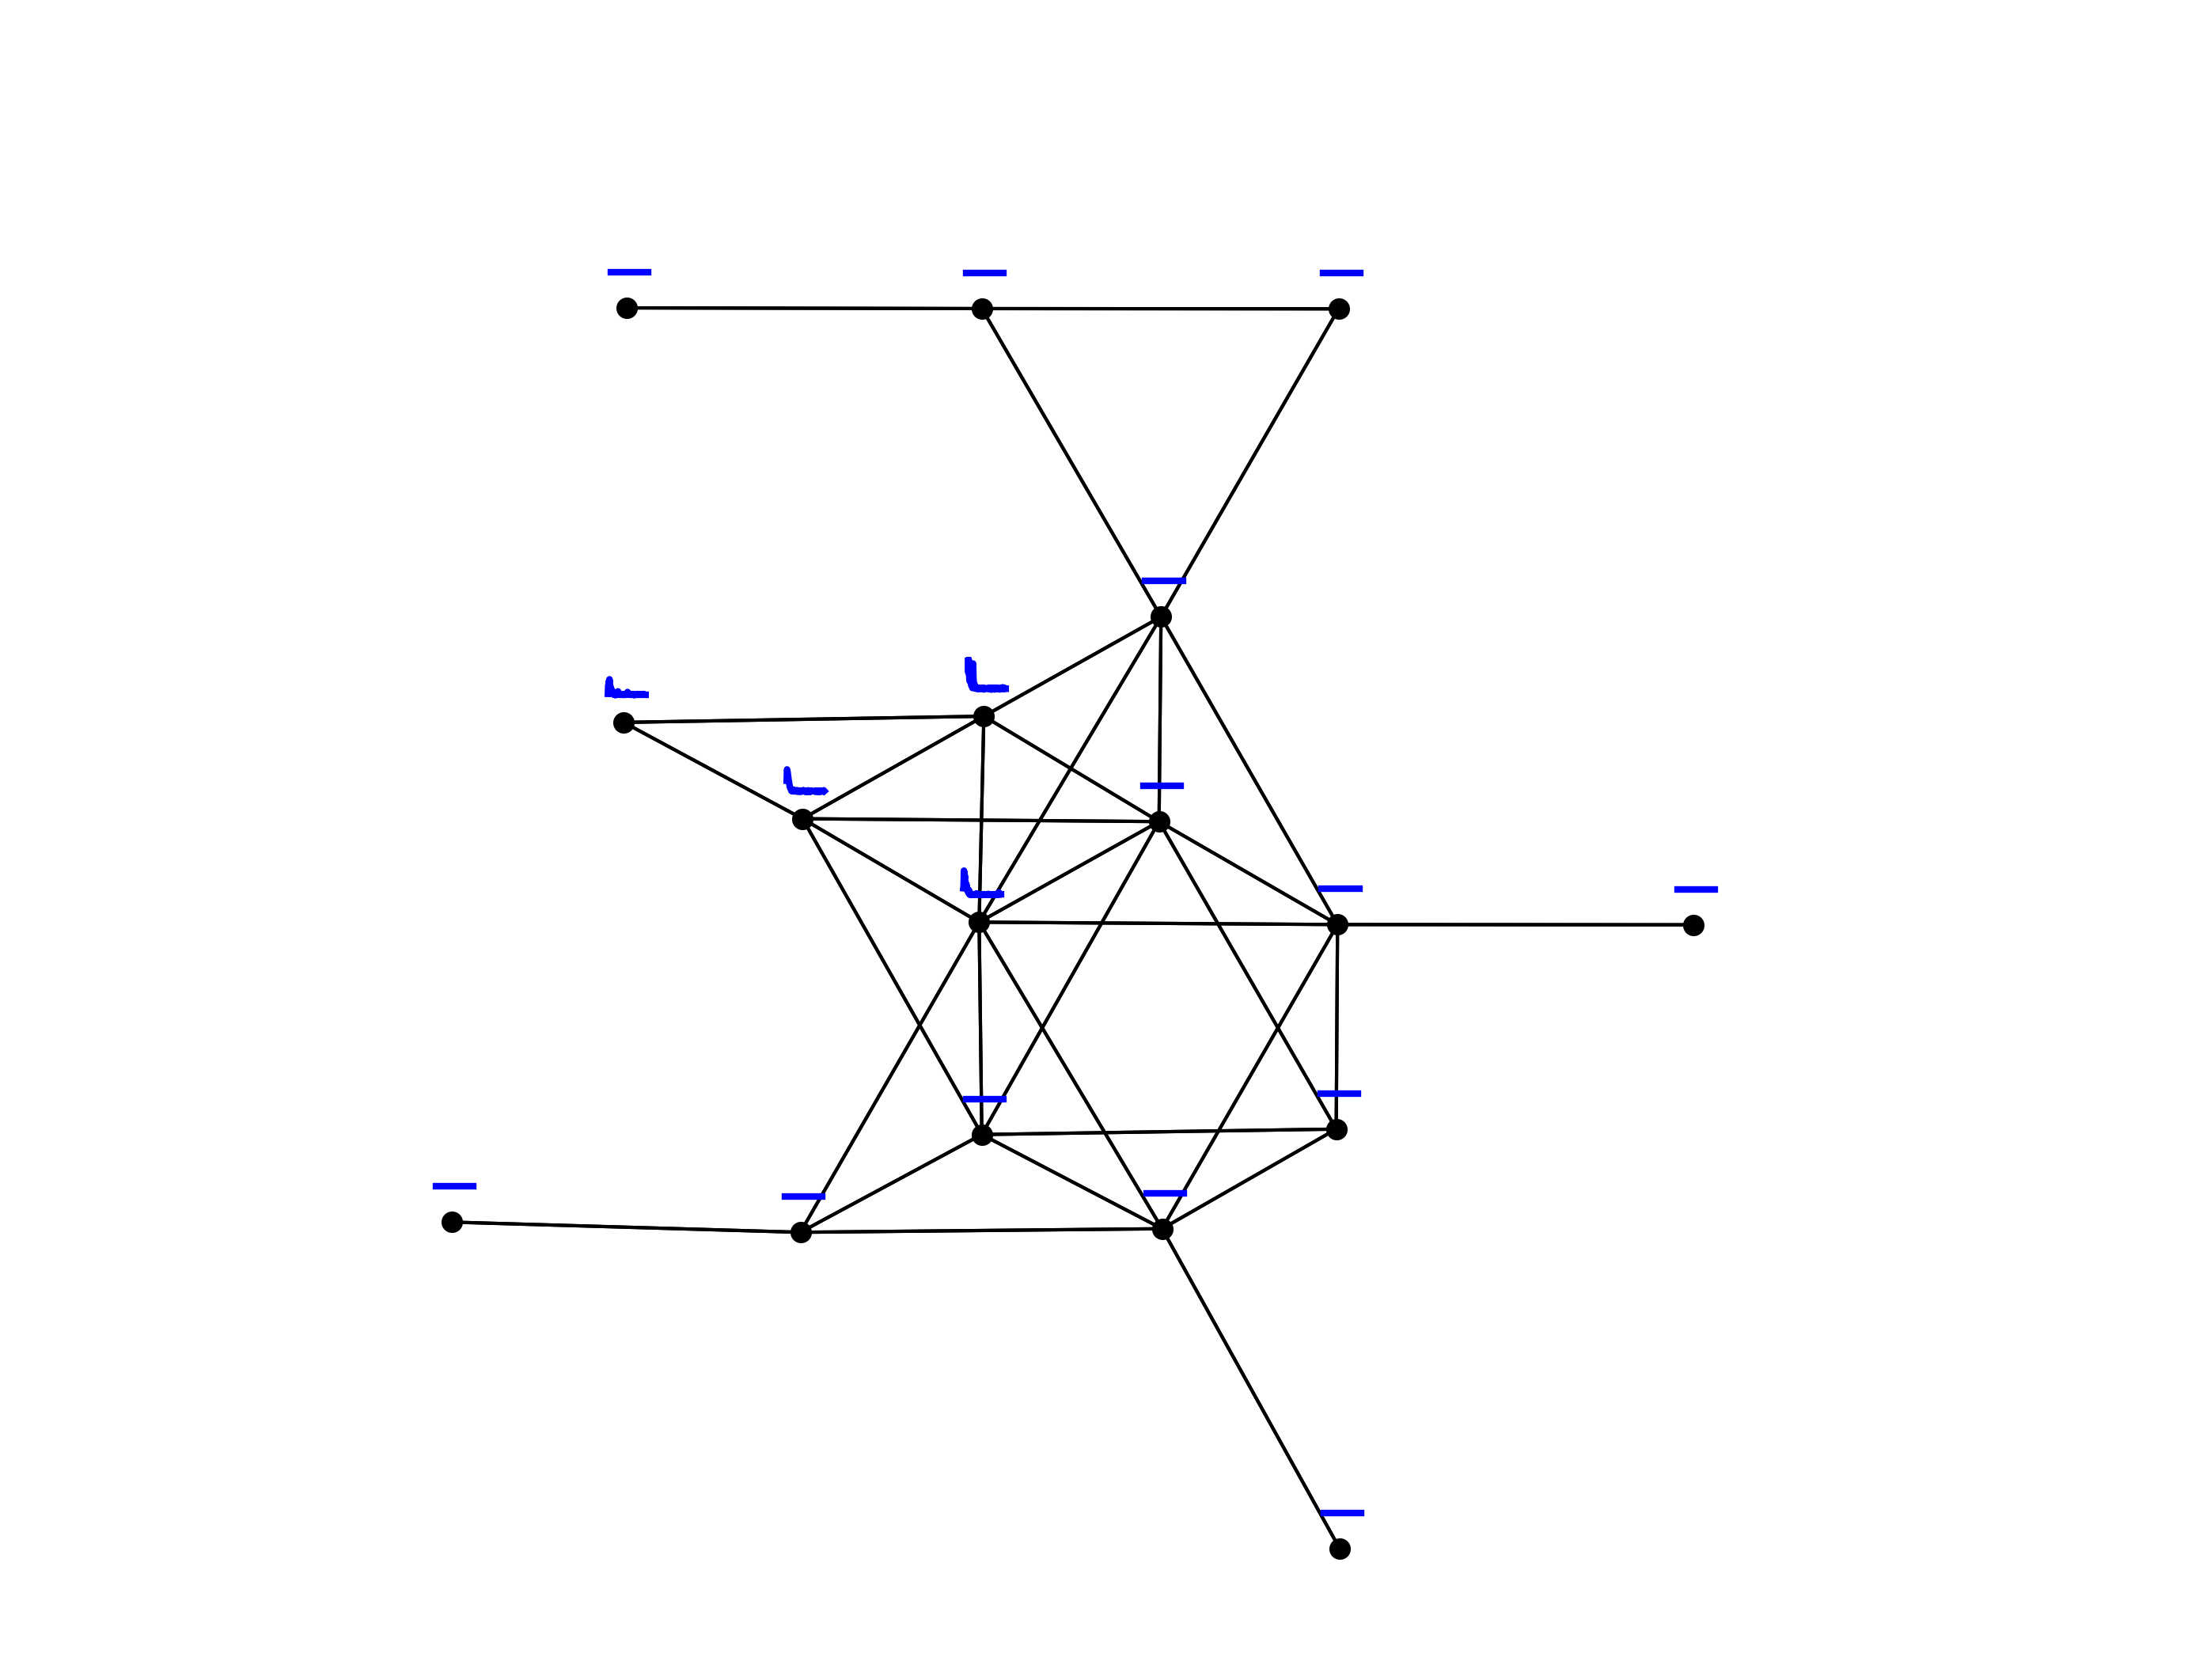

In [69]:
myStyle = MyStyle("1fig", markers=None)
fig, ax = plt.subplots()

color="blue"
kw_args_nodes = {"color":"black"}
kw_args_edges = {"color":"black"}
kw_args_traces = {}

plot_simple_graph(masked_graph1, ax=ax, kw_args_nodes=kw_args_nodes, kw_args_edges=kw_args_edges, kw_args_traces=kw_args_traces)
ax.axis("off")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [75]:
masked_graph1.x[:,6:]

tensor([[ 0.8904,  0.4026],
        [ 0.8904, -0.2262],
        [ 0.8904, -0.0238],
        [ 0.8904, -0.2262],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000]])

In [85]:
counter_masking_transform =  MaskMdCounters(rho_mu_column_idx=7, effective_area_column_idx=6)
masked_graph2 = counter_masking_transform(masked_graph1)

In [86]:
masked_graph2.x[:,6:]

tensor([[ 0.8904,  0.4026],
        [ 0.0000, -2.0000],
        [ 0.8904, -0.0238],
        [ 0.8904, -0.2262],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000]])

## Heterogeneous Graphs

In [10]:
from UHECRs_gnn import SD433UMDatasetHeterogeneous

In [12]:
augmentation_and_normalization_options={"mask_PMTs":True,
                                        "AoP_and_saturation":True,
                                        "log_normalize_traces":True,
                                        "log_normalize_signals":True,
                                        "mask_MD_mods":True}
node_feature_map = {
            "ST": ["x", "y", "z", "deltaTimeHottest"],
            "SD_scalar": ["AoP"], # Spatio-Temporal features at station level
            "MD": ["effective_area", "rho_mu"],        # MD scalar features at module level
        }

normalization_dict = {'x': {'mean': -0.9491140056263119,
                      'std': 435.17005469569324,
                      'method': 'standardization'},
                      'y': {'mean': -0.19531560440948104,
                      'std': 433.9656834433116,
                      'method': 'standardization'},
                      'z': {'mean': -0.14878523419966386,
                      'std': 7.290179865533479,
                      'method': 'standardization'},
                      'deltaTimeHottest': {'mean': -38.075111053956824,
                      'std': 754.8579093385754,
                      'method': 'standardization'},
                      'effective_area': {'min': 0, 'max': 10.46, 'method': 'min_max_scaling'},
                      'rho_mu': {'mean': 2.134929984603,
                      'std': 9.683793095041798,
                      'method': 'standardization'}}

toy_ds = SD433UMDatasetHeterogeneous(file_paths=val_paths,
                                     root=root_path,
                                     augmentation_options=augmentation_and_normalization_options,
                                     normalization_dict=normalization_dict,
                                     node_feature_map=node_feature_map)

In [107]:
hetero_graph = toy_ds[5]

In [108]:
hetero_graph["ST"].x.shape

torch.Size([13, 4])

In [109]:
hetero_graph["SD_trace"].x.shape


torch.Size([29, 120])

In [110]:
hetero_graph["SD_scalar"].x.shape

torch.Size([29, 1])

In [111]:
hetero_graph["MD"].x.shape

torch.Size([28, 2])

In [112]:
hetero_graph["ST", "has_SD_scalar", "SD_scalar"]

{'edge_index': tensor([[ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  6,  7,
          7,  7,  8,  9,  9, 10, 10, 10, 11, 12, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]])}

In [113]:
hetero_graph["ST", "has_SD_trace", "SD_trace"]

{'edge_index': tensor([[ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  6,  7,
          7,  7,  8,  9,  9, 10, 10, 10, 11, 12, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]])}

In [114]:
hetero_graph["ST", "has_MD", "MD"]

{'edge_index': tensor([[ 0,  0,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  6,  7,  7,  7,  8,
          9,  9,  9, 10, 10, 11, 11, 11, 12, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27]])}

In [115]:
hetero_graph["MD"]

{'x': tensor([[ 0.9155, -0.0187],
        [ 0.9155,  0.3001],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.1197],
        [ 0.9155, -0.2205],
        [ 0.9155,  0.0846],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205],
        [ 0.9155, -0.2205]])}

In [116]:
node_features = {
    "ST": ["x", "y", "z", "deltaTimeHottest"],  # Spatio-Temporal node features  # Signal Detector trace features
    "SD_scalar": ["AoP"],                      # Signal Detector scalar features
    "MD": ["effective_area", "rho_mu"],        # Muon Density features
}

normalization_params = toy_ds.compute_normalization_params(node_features)

In [117]:
normalization_params

{'x': {'mean': 0.007390614551177412,
  'std': 0.9977157541148806,
  'method': 'standardization'},
 'y': {'mean': -0.021388340240403828,
  'std': 1.0067859328116118,
  'method': 'standardization'},
 'z': {'mean': -0.0009582908816244573,
  'std': 0.9969068942569093,
  'method': 'standardization'},
 'deltaTimeHottest': {'mean': 0.01962711857998616,
  'std': 1.0125082189955728,
  'method': 'standardization'},
 'AoP': {'mean': 2.9193418977687515,
  'std': 0.1995274746020175,
  'method': 'standardization'},
 'effective_area': {'mean': 0.8681773583839802,
  'std': 0.08322413858482658,
  'method': 'standardization'},
 'rho_mu': {'mean': 0.00862318449754156,
  'std': 1.148559811574714,
  'method': 'standardization'}}

In [118]:
hetero_graph

HeteroData(
  station_list=[13],
  id='Photon_17.0_17.5_030667_05',
  y=1,
  pos=[13, 2],
  core=[2],
  seed=[3],
  Xmax=775.4499999999999,
  Nmu=193533.28125,
  energy_MC=2.01610592e+17,
  electromagnetic_energy=1.996853993002734e+17,
  ST={ x=[13, 4] },
  SD_trace={ x=[29, 120] },
  SD_scalar={ x=[29, 1] },
  MD={ x=[28, 2] },
  (ST, is_neighbour, ST)={ edge_index=[2, 168] },
  (ST, has_SD_trace, SD_trace)={ edge_index=[2, 29] },
  (ST, has_SD_scalar, SD_scalar)={ edge_index=[2, 29] },
  (ST, has_MD, MD)={ edge_index=[2, 28] }
)

In [119]:
hetero_graph.pos

tensor([[ 451376.5000, 6114355.5000],
        [ 451377.7812, 6113930.0000],
        [ 451744.6562, 6114140.0000],
        [ 451747.3750, 6114571.0000],
        [ 451371.3125, 6114788.0000],
        [ 450997.7812, 6114128.5000],
        [ 450992.1562, 6114576.0000],
        [ 451745.1250, 6115007.0000],
        [ 451002.0938, 6115010.0000],
        [ 450622.1562, 6114356.5000],
        [ 451375.4062, 6115219.5000],
        [ 452124.6250, 6113921.0000],
        [ 450620.0000, 6114794.0000]])

In [120]:
def plot_hetero_graph(graph):
    """
    Plots a graph with ST nodes, MD nodes, and SD scalar nodes in a circular layout with edges.

    Args:
        graph (HeteroData): The heterogeneous graph data object.
        positions (torch.Tensor): A tensor of shape (n_ST_nodes, 2) containing x, y positions for all ST nodes.
    """
    # Ensure positions is in numpy format for plotting
    positions = graph.pos.numpy()

    # Create the plot
    myStyle = MyStyle("1fig", markers=None)
    fig, ax = plt.subplots()

    # Plot all edges first with lower z-order
    for st_idx, (x, y) in enumerate(positions):
        radius = 100  # Fixed radius for MD and SD scalar nodes

        # Plot edges between ST nodes in grey
        if ("ST", "is_neighbour", "ST") in graph.edge_types:
            st_edges = graph["ST", "is_neighbour", "ST"].edge_index
            neighbors = st_edges[1, st_edges[0] == st_idx].numpy()
            for neighbor in neighbors:
                neighbor_x, neighbor_y = positions[neighbor]
                ax.plot([x, neighbor_x], [y, neighbor_y], c='grey', linewidth=1, alpha=0.5, zorder=1)

        # Plot edges for connected MD nodes
        if ("ST", "has_MD", "MD") in graph.edge_types:
            md_edges = graph["ST", "has_MD", "MD"].edge_index
            connected_md_indices = md_edges[1, md_edges[0] == st_idx].numpy()
            for md_idx, md_node in enumerate(connected_md_indices):
                angle = 2 * np.pi / 12 * md_idx
                md_x = x + radius * np.cos(angle)
                md_y = y + radius * np.sin(angle)
                ax.plot([x, md_x], [y, md_y], c='lightblue', linewidth=1, alpha=0.5, zorder=1)

        # Plot edges for connected SD scalar nodes
        if ("ST", "has_SD_scalar", "SD_scalar") in graph.edge_types:
            sd_edges = graph["ST", "has_SD_scalar", "SD_scalar"].edge_index
            connected_sd_indices = sd_edges[1, sd_edges[0] == st_idx].numpy()
            for sd_idx, sd_node in enumerate(connected_sd_indices):
                angle = 2 * np.pi / 12 * (len(connected_md_indices) + sd_idx)
                sd_x = x + radius * np.cos(angle)
                sd_y = y + radius * np.sin(angle)
                ax.plot([x, sd_x], [y, sd_y], c='pink', linewidth=1, alpha=0.5, zorder=1)

    # Plot all nodes (markers) with higher z-order
    for st_idx, (x, y) in enumerate(positions):
        radius = 100  # Fixed radius for MD and SD scalar nodes

        # Plot connected MD nodes
        if ("ST", "has_MD", "MD") in graph.edge_types:
            md_edges = graph["ST", "has_MD", "MD"].edge_index
            connected_md_indices = md_edges[1, md_edges[0] == st_idx].numpy()
            for md_idx, md_node in enumerate(connected_md_indices):
                angle = 2 * np.pi / 12 * md_idx
                md_x = x + radius * np.cos(angle)
                md_y = y + radius * np.sin(angle)
                ax.scatter(md_x, md_y, s=150, c='blue', zorder=2, label='MD module' if st_idx == 0 and md_idx == 0 else None)

        # Plot connected SD scalar nodes
        if ("ST", "has_SD_scalar", "SD_scalar") in graph.edge_types:
            sd_edges = graph["ST", "has_SD_scalar", "SD_scalar"].edge_index
            connected_sd_indices = sd_edges[1, sd_edges[0] == st_idx].numpy()
            for sd_idx, sd_node in enumerate(connected_sd_indices):
                angle = 2 * np.pi / 12 * (len(connected_md_indices) + sd_idx)
                sd_x = x + radius * np.cos(angle)
                sd_y = y + radius * np.sin(angle)
                ax.scatter(sd_x, sd_y, s=150, c='red', marker='s', zorder=2, label='L-PMT' if st_idx == 0 and sd_idx == 0 else None)

    # Plot ST nodes as large black circles
    ax.scatter(positions[:, 0], positions[:, 1], s=300, c='black', zorder=3, label='ST Nodes')

    # Add legend and show the plot
    plt.legend(loc='upper right')
    ax.set_xlabel("easting / m")
    ax.set_ylabel("northing / m")
    plt.axis("equal")  # Maintain aspect ratio
    plt.show()

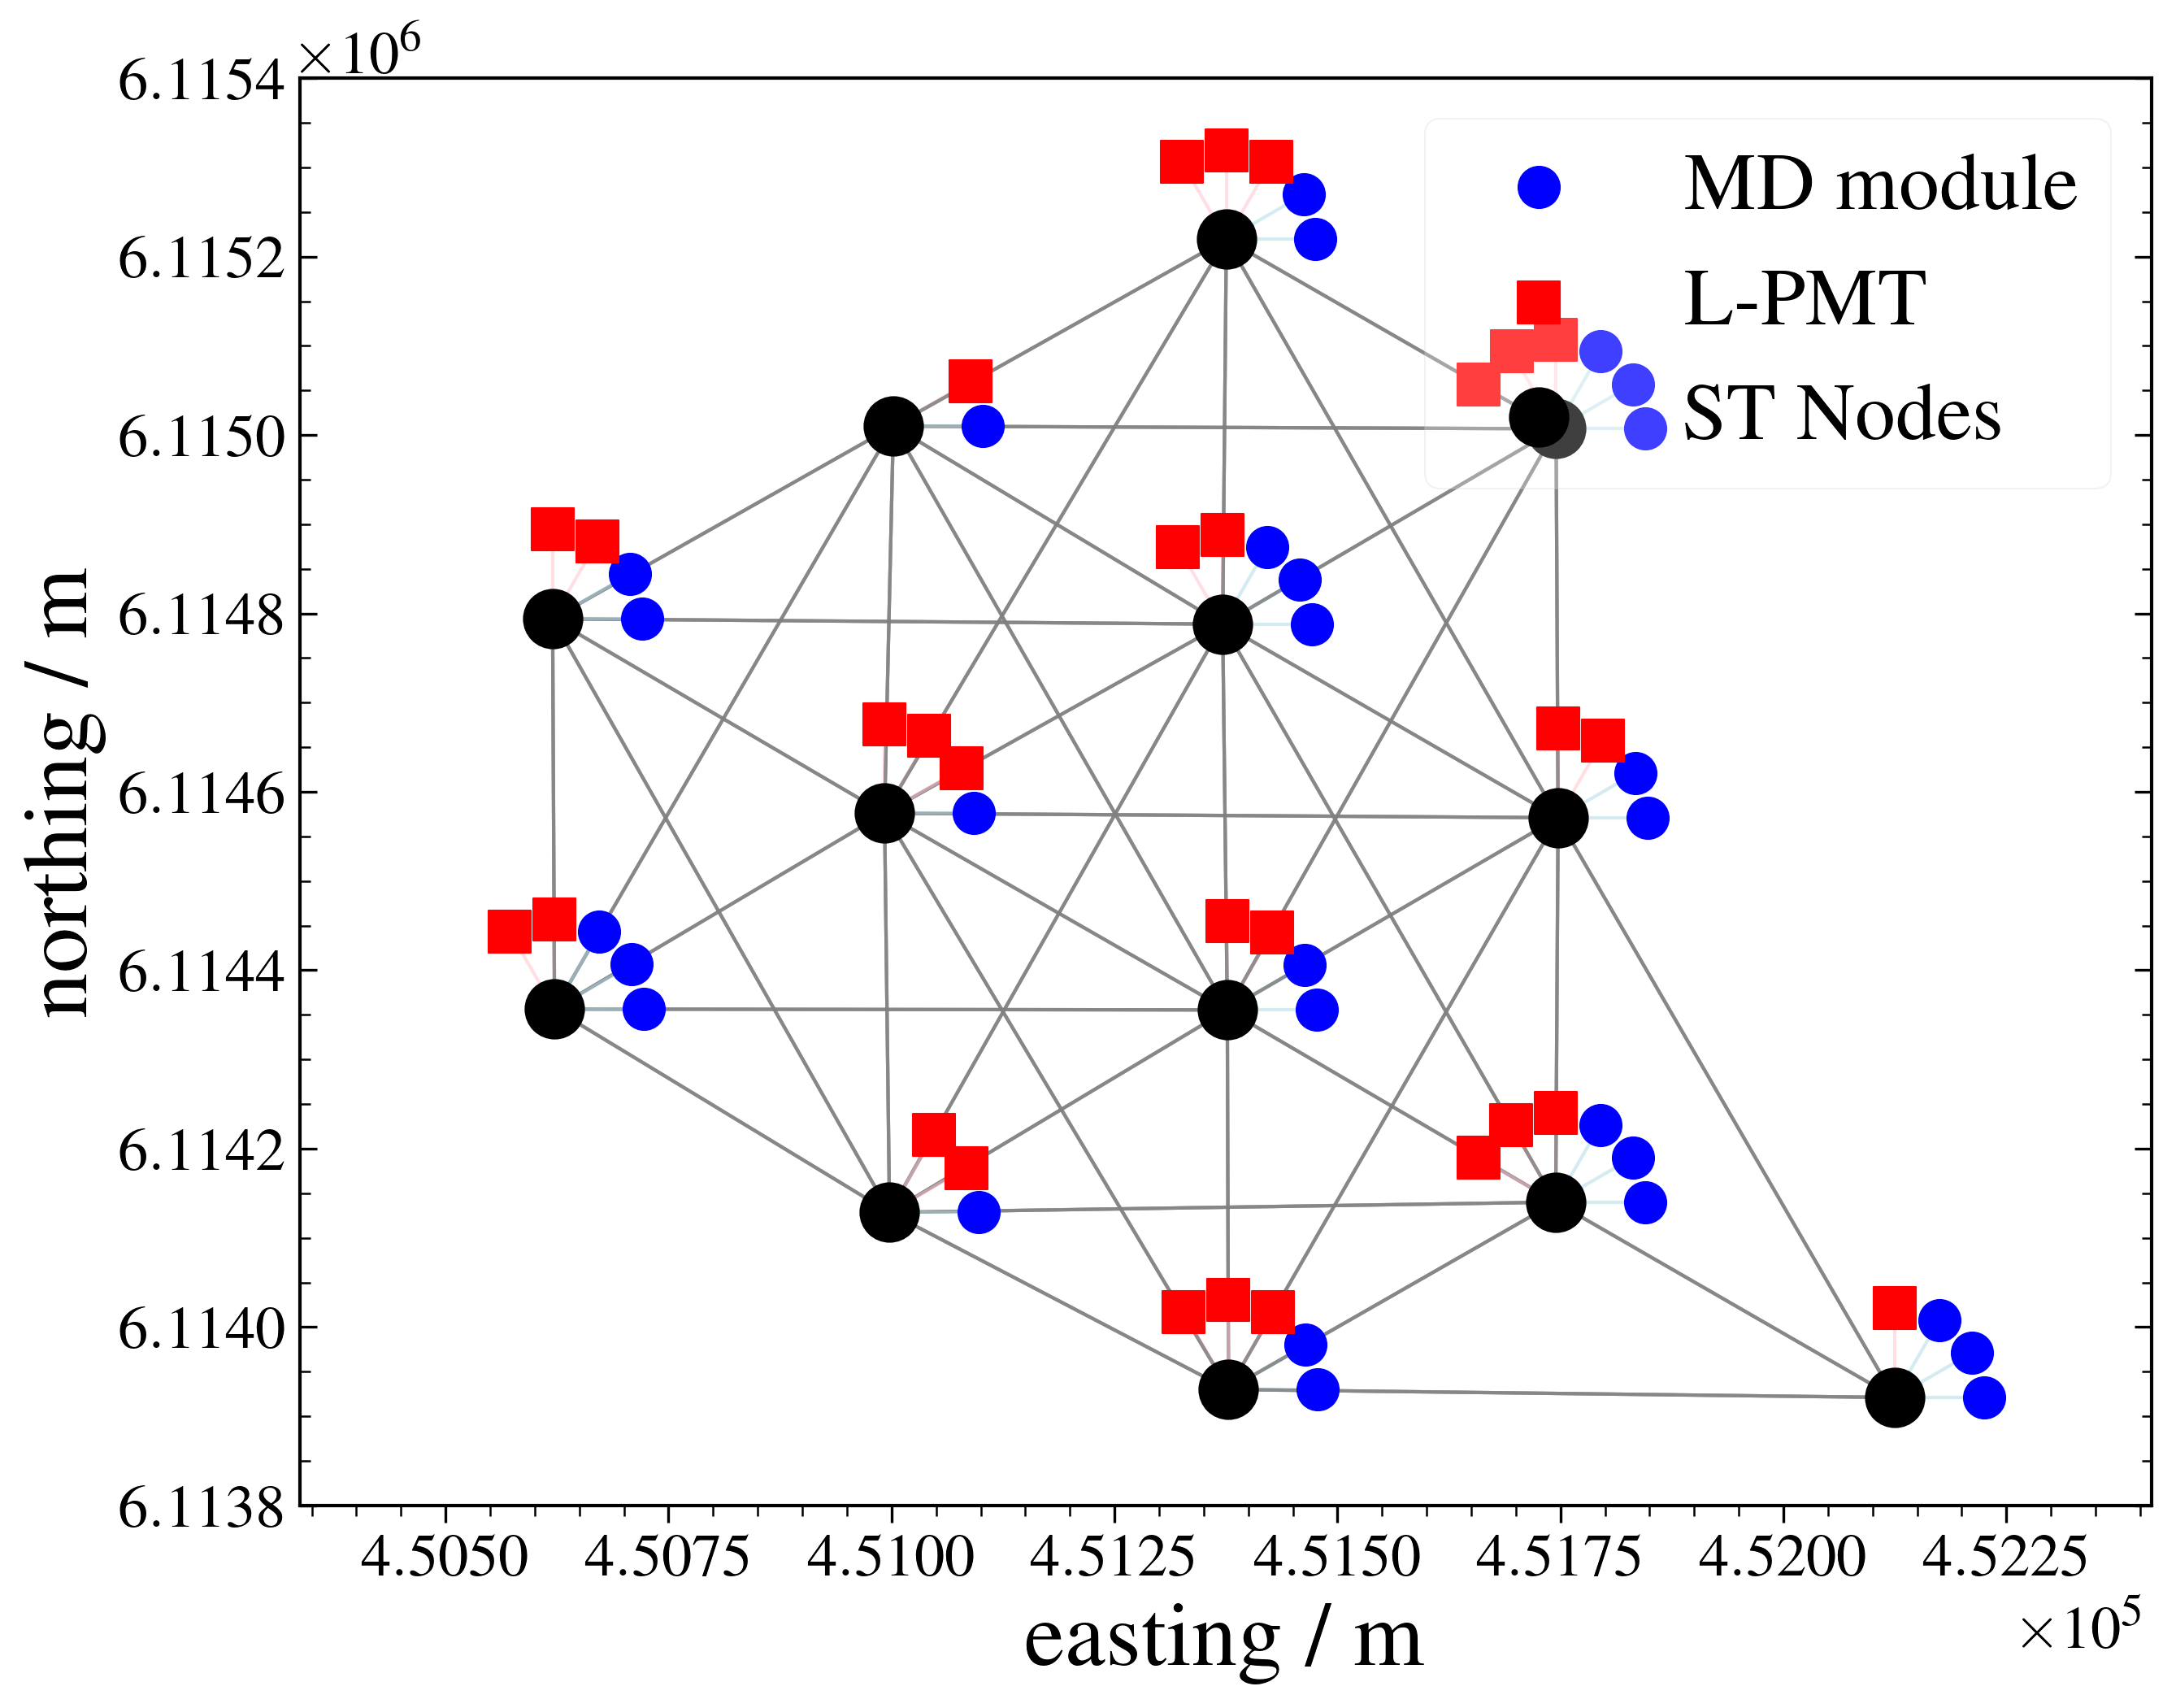

In [121]:
plot_hetero_graph(hetero_graph)

In [150]:
hetero_graph[("ST","is_neighbour","ST")].edge_index

tensor([[ 0,  1,  0,  2,  0,  3,  0,  4,  0,  5,  0,  6,  0,  7,  0,  8,  0,  9,
          1,  0,  1,  2,  1,  3,  1,  5,  1,  6,  1, 11,  2,  0,  2,  1,  2,  3,
          2,  4,  2,  5,  2, 11,  3,  0,  3,  1,  3,  2,  3,  4,  3,  6,  3,  7,
          3, 10,  3, 11,  4,  0,  4,  2,  4,  3,  4,  5,  4,  6,  4,  7,  4,  8,
          4, 10,  4, 12,  5,  0,  5,  1,  5,  2,  5,  4,  5,  6,  5,  9,  5, 12,
          6,  0,  6,  1,  6,  3,  6,  4,  6,  5,  6,  8,  6,  9,  6, 10,  6, 12,
          7,  0,  7,  3,  7,  4,  7,  8,  7, 10,  8,  0,  8,  4,  8,  6,  8,  7,
          8,  9,  8, 10,  8, 12,  9,  0,  9,  5,  9,  6,  9,  8,  9, 12, 10,  3,
         10,  4, 10,  6, 10,  7, 10,  8, 11,  1, 11,  2, 11,  3, 12,  4, 12,  5,
         12,  6, 12,  8, 12,  9],
        [ 1,  0,  2,  0,  3,  0,  4,  0,  5,  0,  6,  0,  7,  0,  8,  0,  9,  0,
          0,  1,  2,  1,  3,  1,  5,  1,  6,  1, 11,  1,  0,  2,  1,  2,  3,  2,
          4,  2,  5,  2, 11,  2,  0,  3,  1,  3,  2,  3,  4,  3,  6,  3,  7

In [149]:
hetero_graph[("ST","has_MD","MD")].edge_index

tensor([[ 0,  0,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  6,  7,  7,  7,  8,
          9,  9,  9, 10, 10, 11, 11, 11, 12, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27]])

In [169]:
import random
from torch_geometric.data import Dataset, Data, Batch, HeteroData
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import subgraph, dropout_node

class DropSTNodes(BaseTransform):
    def __init__(self, max_nodes_to_drop: int):
        """
        Args:
            max_nodes_to_drop (int): Maximum number of ST nodes to drop per graph.
        """
        super(DropSTNodes, self).__init__()
        self.max_nodes_to_drop = max_nodes_to_drop

    def __call__(self, input_data: HeteroData) -> HeteroData:
        data = input_data.clone()  # Clone the input data to avoid modifying the original

        if "ST" not in data.node_types or not hasattr(data, "station_list") or not hasattr(data, "seed"):
            raise ValueError("The input data must have 'ST', 'station_list', and 'seed' attributes.")

        n_st_nodes = data["ST"].x.size(0)
        if n_st_nodes == 0:
            raise ValueError("The input data contains no ST nodes to drop.")

        # Step 1: Select ST nodes to drop
        seed_ids = set(data.seed)
        seed_indices = [i for i, station_id in enumerate(data.station_list) if station_id in seed_ids]

        droppable_indices = [i for i in range(n_st_nodes) if i not in seed_indices]
        if not droppable_indices:
            warnings.warn("No droppable ST nodes available (all nodes are seeds).")
            return data

        n_nodes_to_drop = random.randint(0, min(self.max_nodes_to_drop, len(droppable_indices)))
        nodes_to_drop = random.sample(droppable_indices, n_nodes_to_drop)

        keep_mask_st = torch.ones(n_st_nodes, dtype=torch.bool)
        keep_mask_st[nodes_to_drop] = False

        # Step 2: Create ST node mapping and update features
        relabel_map_st = torch.full((n_st_nodes,), -1, dtype=torch.long)
        relabel_map_st[keep_mask_st] = torch.arange(keep_mask_st.sum())

        data["ST"].x = data["ST"].x[keep_mask_st]
        data.station_list = [station_id for i, station_id in enumerate(data.station_list) if keep_mask_st[i]]
        data.pos = data.pos[keep_mask_st]

        # Update ST-to-ST edges
        for edge_type in list(data.edge_index_dict.keys()):
            src, _, dst = edge_type
            if src == "ST" and dst == "ST":
                edge_index = data[edge_type].edge_index
                src_relabel = relabel_map_st[edge_index[0]]
                dst_relabel = relabel_map_st[edge_index[1]]
                valid_mask = (src_relabel >= 0) & (dst_relabel >= 0)
                edge_index = edge_index[:, valid_mask]
                edge_index[0] = src_relabel[valid_mask]
                edge_index[1] = dst_relabel[valid_mask]
                data[edge_type].edge_index = edge_index

        # Step 3: Process other node types
        for node_type in data.node_types:
            if node_type == "ST":
                continue

            # Create mapping for the current node type
            n_nodes = data[node_type].x.size(0)
            keep_mask_node = torch.ones(n_nodes, dtype=torch.bool)

            # Identify nodes connected to dropped ST nodes
            for edge_type in list(data.edge_index_dict.keys()):
                src, _, dst = edge_type
                if src == "ST" and dst == node_type:
                    edge_index = data[edge_type].edge_index
                    connected_nodes = edge_index[1][relabel_map_st[edge_index[0]] == -1]
                    keep_mask_node[connected_nodes] = False

            relabel_map_node = torch.full((n_nodes,), -1, dtype=torch.long)
            relabel_map_node[keep_mask_node] = torch.arange(keep_mask_node.sum())

            # Update node features
            data[node_type].x = data[node_type].x[keep_mask_node]

            # Update edges for the current node type
            for edge_type in list(data.edge_index_dict.keys()):
                src, _, dst = edge_type
                if src == "ST" and dst == node_type:
                    edge_index = data[edge_type].edge_index
                    src_relabel = relabel_map_st[edge_index[0]]
                    dst_relabel = relabel_map_node[edge_index[1]]
                    valid_mask = (src_relabel >= 0) & (dst_relabel >= 0)
                    edge_index = edge_index[:, valid_mask]
                    edge_index[0] = src_relabel[valid_mask]
                    edge_index[1] = dst_relabel[valid_mask]
                    data[edge_type].edge_index = edge_index

                elif src == node_type and dst == "ST":
                    edge_index = data[edge_type].edge_index
                    src_relabel = relabel_map_node[edge_index[0]]
                    dst_relabel = relabel_map_st[edge_index[1]]
                    valid_mask = (src_relabel >= 0) & (dst_relabel >= 0)
                    edge_index = edge_index[:, valid_mask]
                    edge_index[0] = src_relabel[valid_mask]
                    edge_index[1] = dst_relabel[valid_mask]
                    data[edge_type].edge_index = edge_index

        return data

    def collate(self, batch: Batch) -> Batch:
        """
        Collate function to apply the transformation to a batch of graphs.

        Args:
            batch (Batch): A batch of heterogeneous graphs.

        Returns:
            Batch: Transformed batch.
        """
        new_graphs = []
        for graph_batch_id in torch.unique(batch.batch):
            graph_mask = graph_batch_id == batch.batch

            # Extract graph-specific data
            _graph = batch.subgraph(graph_mask)

            # Preserve additional fields
            for field in [
                "station_list",
                "id",
                "y",
                "pos",
                "core",
                "seed",
                "Xmax",
                "Nmu",
                "energy_MC",
                "electromagnetic_energy",
            ]:
                if hasattr(batch, field):
                    setattr(_graph, field, getattr(batch, field)[graph_batch_id])

            # Apply the transformation
            transformed_graph = self(_graph)
            new_graphs.append(transformed_graph)

        return Batch.from_data_list(new_graphs)

class DropNodesBySTSelection(BaseTransform):
    def __init__(self, max_st_nodes: int, target_node_type: str, drop_from_seed: bool = False):
        """
        Args:
            max_nodes_to_select (int): Maximum number of ST nodes to select per graph.
            target_node_type (str): The type of nodes connected to the selected ST nodes to drop.
            drop_from_seed (bool): Whether to drop nodes connected to seed ST nodes.
        """
        super(DropNodesBySTSelection, self).__init__()
        self.max_nodes_to_select = max_st_nodes
        self.target_node_type = target_node_type
        self.drop_from_seed = drop_from_seed

    def __call__(self, input_data: HeteroData) -> HeteroData:
        data = input_data.clone()  # Clone the input data to avoid modifying the original

        if "ST" not in data.node_types or self.target_node_type not in data.node_types:
            raise ValueError("The input data must have 'ST' and the specified target node type.")

        n_st_nodes = data["ST"].x.size(0)
        if n_st_nodes == 0:
            raise ValueError("The input data contains no ST nodes to select.")

        # Step 1: Select ST nodes to drop
        seed_ids = set(data.seed)
        seed_indices = [i for i, station_id in enumerate(data.station_list) if station_id in seed_ids]

        # Determine ST nodes eligible for selection
        if self.drop_from_seed:
            droppable_indices = list(range(n_st_nodes))  # Include all ST nodes, including seeds
        else:
            droppable_indices = [i for i in range(n_st_nodes) if i not in seed_indices]

        if not droppable_indices:
            warnings.warn("No droppable ST nodes available.")
            return data

        n_nodes_to_select = random.randint(0, min(self.max_nodes_to_select, len(droppable_indices)))
        nodes_to_select = random.sample(droppable_indices, n_nodes_to_select)

        keep_mask_st = torch.ones(n_st_nodes, dtype=torch.bool)
        keep_mask_st[nodes_to_select] = False

        # Step 2: Process the target node type
        n_target_nodes = data[self.target_node_type].x.size(0)
        keep_mask_target = torch.ones(n_target_nodes, dtype=torch.bool)
        relabel_map_target = torch.full((n_target_nodes,), -1, dtype=torch.long)

        for st_node in nodes_to_select:
            # Find target nodes connected to the current ST node
            for edge_type in list(data.edge_index_dict.keys()):
                src, _, dst = edge_type
                if src == "ST" and dst == self.target_node_type:
                    edge_index = data[edge_type].edge_index
                    connected_target_nodes = edge_index[1][edge_index[0] == st_node]
                    keep_mask_target[connected_target_nodes] = False

        # Update the relabel map for the target node type
        relabel_map_target[keep_mask_target] = torch.arange(keep_mask_target.sum())

        # Step 3: Update target node features
        data[self.target_node_type].x = data[self.target_node_type].x[keep_mask_target]

        # Step 4: Update target-related edges
        for edge_type in list(data.edge_index_dict.keys()):
            src, _, dst = edge_type
            if src == self.target_node_type or dst == self.target_node_type:
                edge_index = data[edge_type].edge_index
        
                # Relabel source and destination using the appropriate relabel maps
                src_relabel = (
                    relabel_map_target[edge_index[0]]
                    if src == self.target_node_type
                    else edge_index[0]
                )
                dst_relabel = (
                    relabel_map_target[edge_index[1]]
                    if dst == self.target_node_type
                    else edge_index[1]
                )
        
                # Filter out edges where relabeling failed (-1 indicates dropped nodes)
                valid_mask = (src_relabel >= 0) & (dst_relabel >= 0)
                edge_index = edge_index[:, valid_mask]
        
                # Relabel valid edges
                if src == self.target_node_type:
                    edge_index[0] = src_relabel[valid_mask]
                if dst == self.target_node_type:
                    edge_index[1] = dst_relabel[valid_mask]
        
                data[edge_type].edge_index = edge_index
        return data

    def collate(self, batch: Batch) -> Batch:
        """
        Collate function to apply the transformation to a batch of graphs.

        Args:
            batch (Batch): A batch of heterogeneous graphs.

        Returns:
            Batch: Transformed batch.
        """
        new_graphs = []
        for graph_batch_id in torch.unique(batch.batch):
            graph_mask = graph_batch_id == batch.batch

            # Extract graph-specific data
            _graph = batch.subgraph(graph_mask)

            # Preserve additional fields
            for field in [
                "station_list",
                "id",
                "y",
                "pos",
                "core",
                "seed",
                "Xmax",
                "Nmu",
                "energy_MC",
                "electromagnetic_energy",
            ]:
                if hasattr(batch, field):
                    setattr(_graph, field, getattr(batch, field)[graph_batch_id])

            # Apply the transformation
            transformed_graph = self(_graph)
            new_graphs.append(transformed_graph)

        return Batch.from_data_list(new_graphs)

masking_transformation_ST = DropSTNodes(max_nodes_to_drop=2)
masking_transformation_MD = DropNodesBySTSelection(target_node_type="MD", max_st_nodes=2, drop_from_seed=True) 

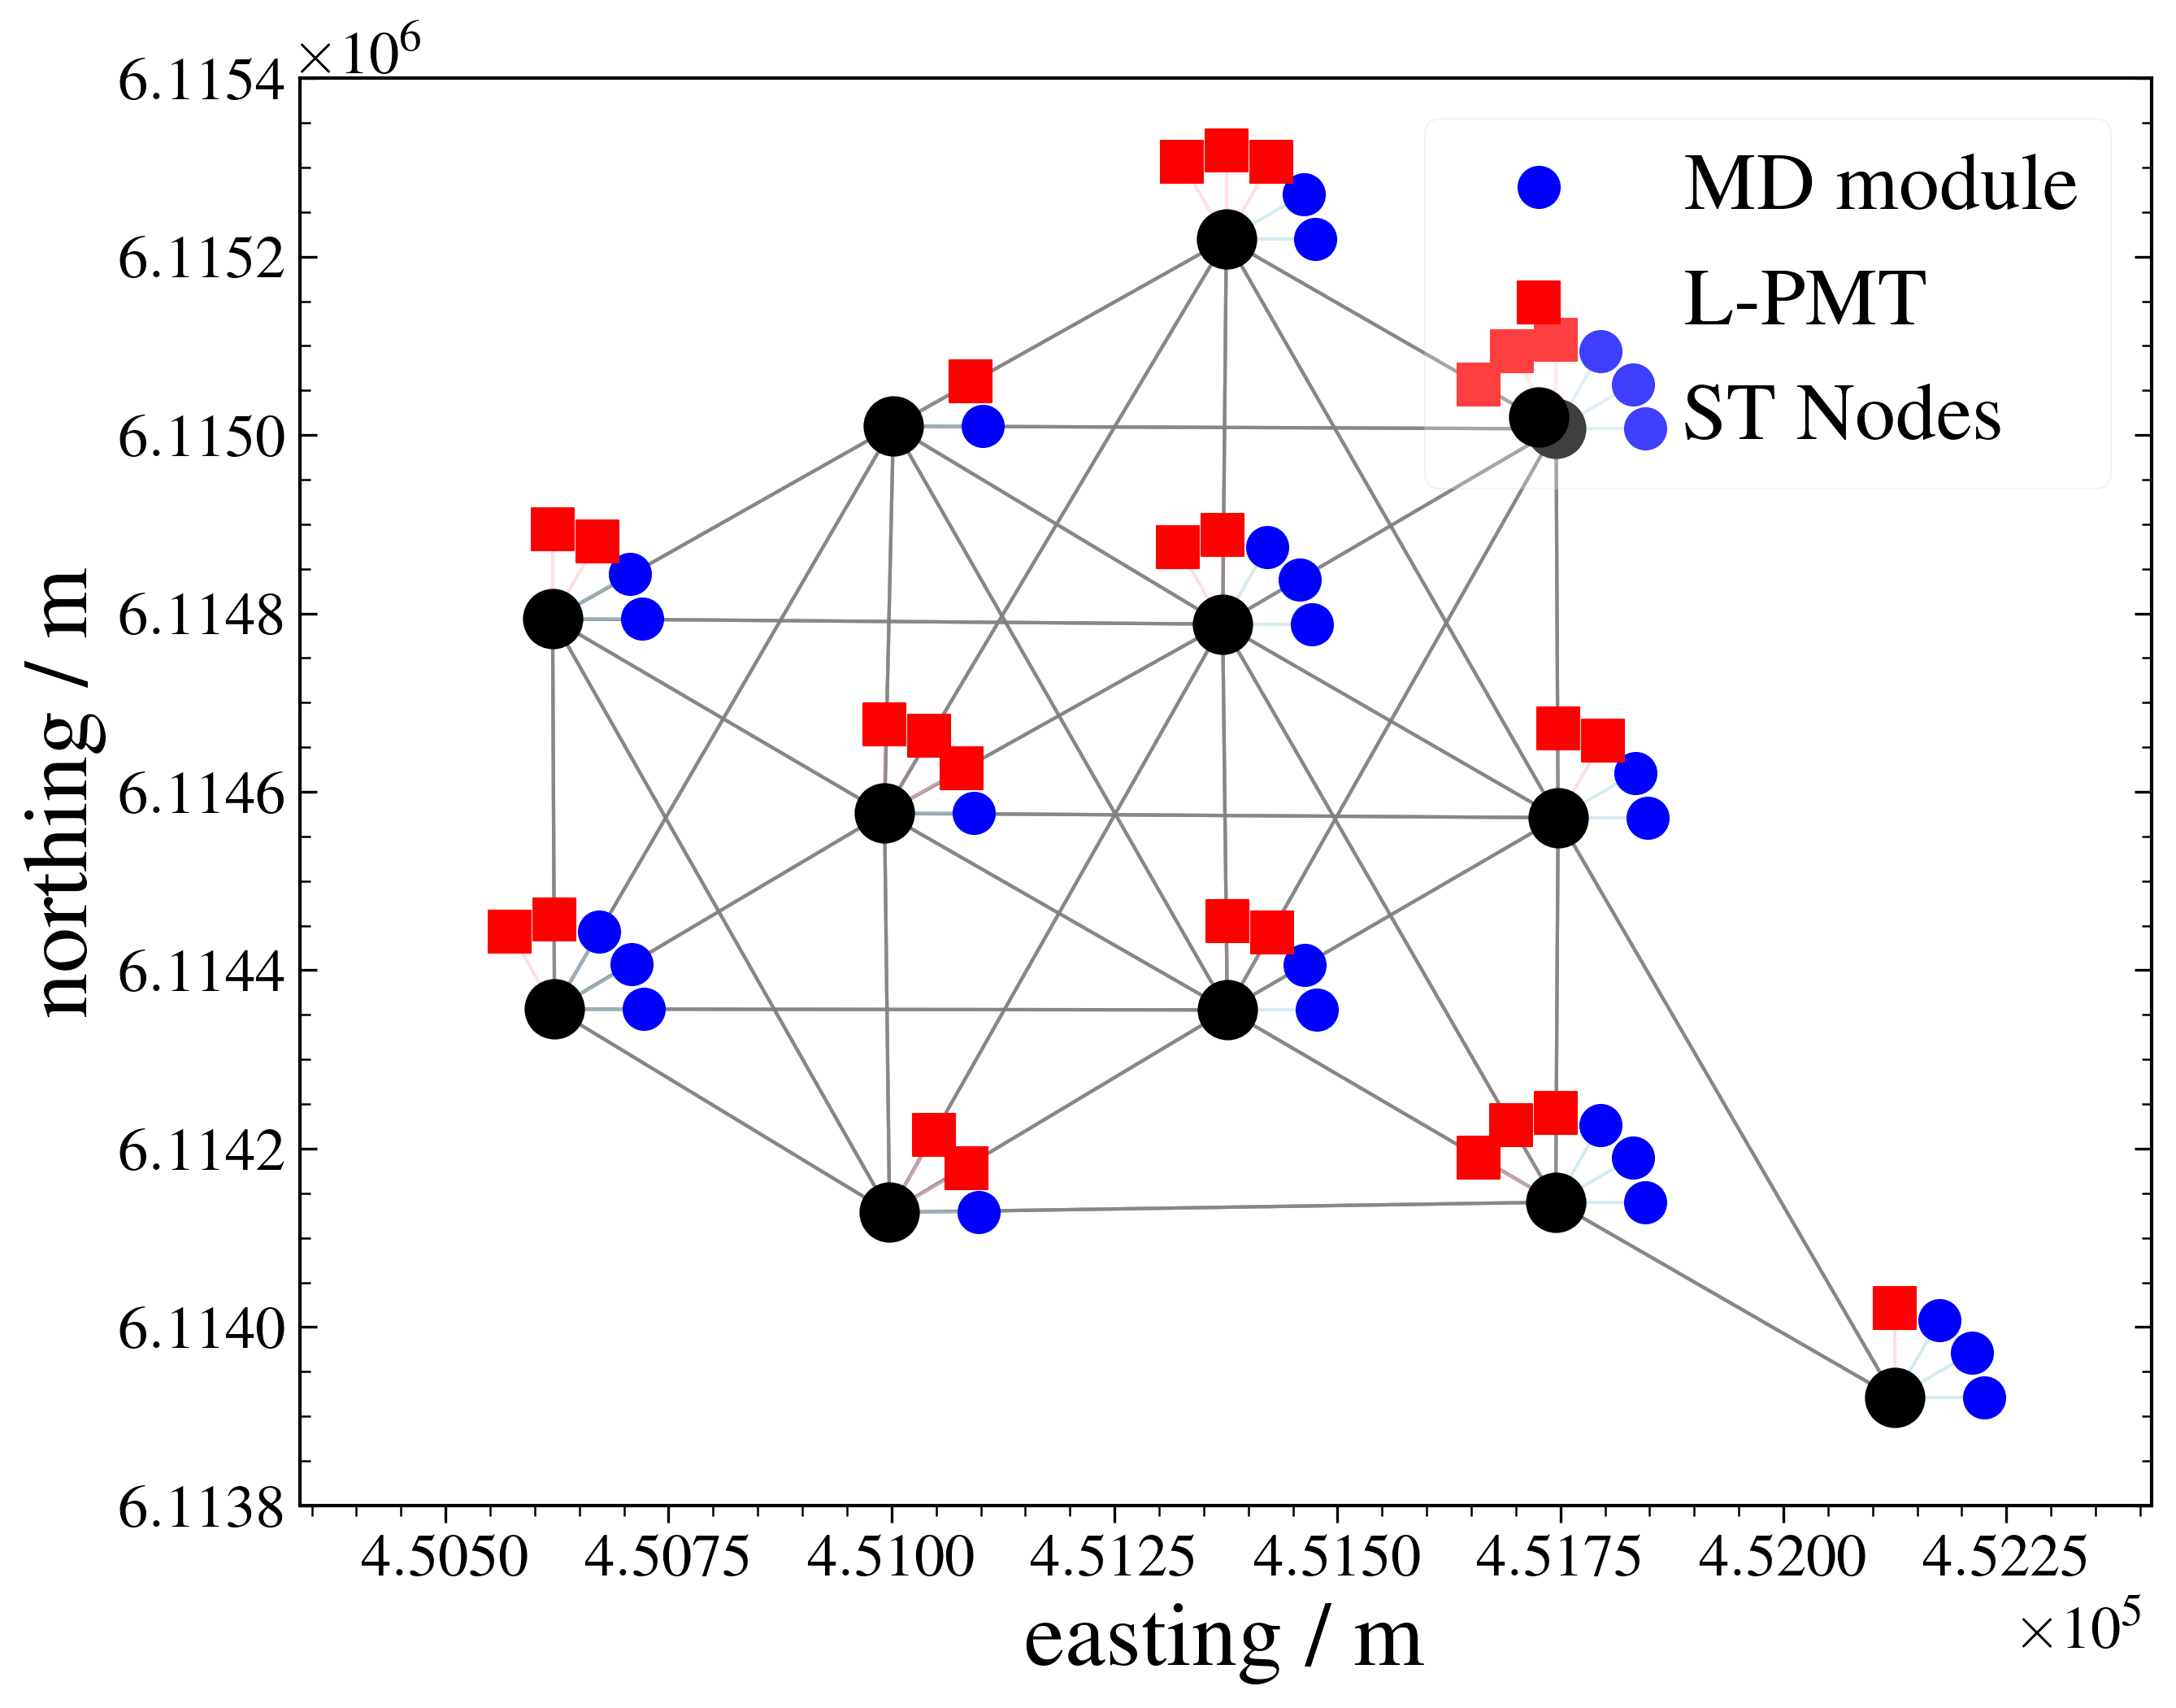

In [170]:
transformed_graph_1 = masking_transformation_ST(hetero_graph)
plot_hetero_graph(transformed_graph_1)

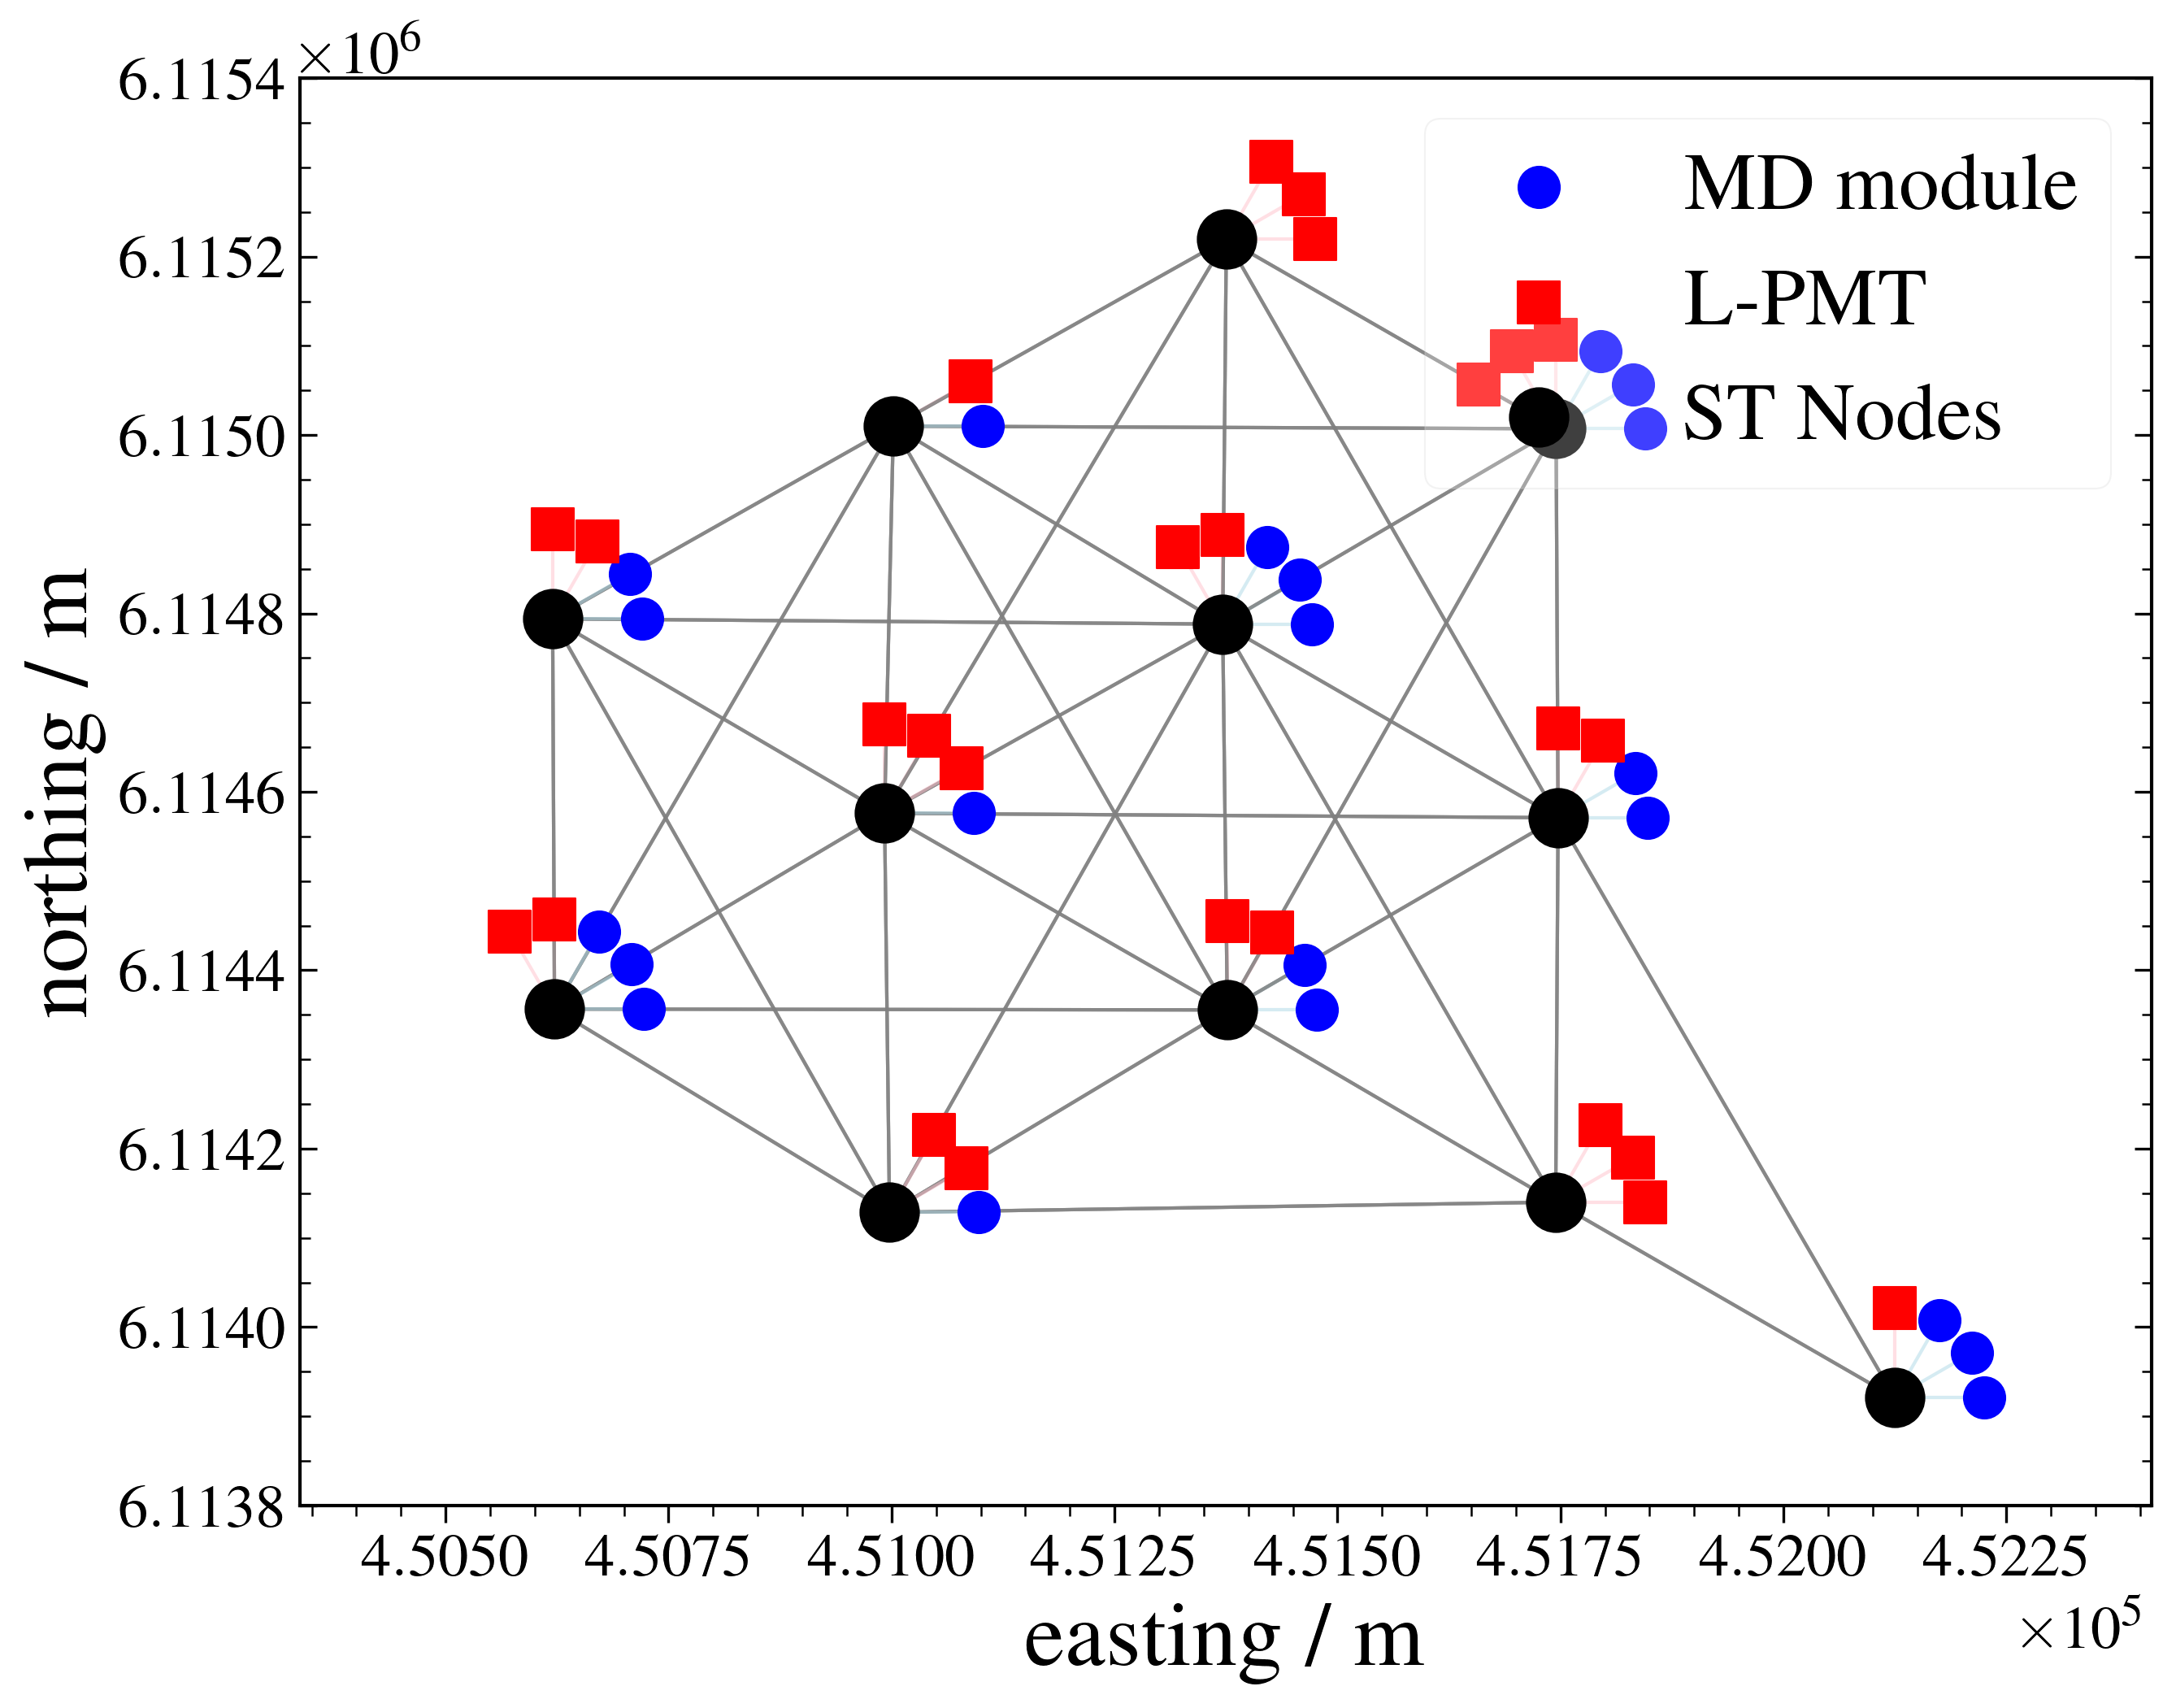

In [175]:
transformed_graph_2 = masking_transformation_MD(transformed_graph_1)
plot_hetero_graph(transformed_graph_2)